# contens

1. Libarary import
2. Data Browser
3. EDA
4. Data Preprocessing & Cross Validation

## 1. Library improt

In [1]:
import numpy as np
import pandas as pd
import os
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.linear_model import *
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

os.chdir('C:/elec_used/data/energy')
#os.chdir('/home/lyj/elec_used/data/energy')

In [2]:
os.listdir('C:/elec_used/data/energy')
#os.listdir('/home/lyj/elec_used/data/energy')

['sample_submission.csv', 'test.csv', 'train.csv']

In [3]:
train = pd.read_csv('train.csv', encoding = 'euc-kr')
test = pd.read_csv('test.csv', encoding = 'euc-kr')
submission = pd.read_csv('sample_submission.csv', encoding='euc-kr')

In [4]:
train.head(10)

num      date_time  전력사용량(kWh)  기온(°C)  풍속(m/s)  습도(%)  강수량(mm)  일조(hr)  \
0    1  2020-06-01 00    8179.056    17.6      2.5   92.0      0.8     0.0   
1    1  2020-06-01 01    8135.640    17.7      2.9   91.0      0.3     0.0   
2    1  2020-06-01 02    8107.128    17.5      3.2   91.0      0.0     0.0   
3    1  2020-06-01 03    8048.808    17.1      3.2   91.0      0.0     0.0   
4    1  2020-06-01 04    8043.624    17.0      3.3   92.0      0.0     0.0   
5    1  2020-06-01 05    8010.576    16.9      3.4   93.0      0.0     0.0   
6    1  2020-06-01 06    7978.176    16.7      3.4   90.0      0.1     0.0   
7    1  2020-06-01 07    8019.000    16.9      2.3   86.0      0.0     0.1   
8    1  2020-06-01 08    8020.944    17.8      3.3   80.0      0.0     0.3   
9    1  2020-06-01 09    8083.152    19.3      2.1   73.0      0.0     0.7   

   비전기냉방설비운영  태양광보유  
0        0.0    0.0  
1        0.0    0.0  
2        0.0    0.0  
3        0.0    0.0  
4        0.0    0.0  
5        0.0    0.0  
6        0.0    0.0  
7        0.0    0.0  
8        0.0    0.0  
9        0.0    0.0

In [5]:
test.head(10)

num      date_time  기온(°C)  풍속(m/s)  습도(%)  강수량(mm, 6시간)  일조(hr, 3시간)  \
0    1  2020-08-25 00    27.8      1.5   74.0           0.0          0.0   
1    1  2020-08-25 01     NaN      NaN    NaN           NaN          NaN   
2    1  2020-08-25 02     NaN      NaN    NaN           NaN          NaN   
3    1  2020-08-25 03    27.3      1.1   78.0           NaN          0.0   
4    1  2020-08-25 04     NaN      NaN    NaN           NaN          NaN   
5    1  2020-08-25 05     NaN      NaN    NaN           NaN          NaN   
6    1  2020-08-25 06    26.1      1.3   83.0           0.0          0.0   
7    1  2020-08-25 07     NaN      NaN    NaN           NaN          NaN   
8    1  2020-08-25 08     NaN      NaN    NaN           NaN          NaN   
9    1  2020-08-25 09    28.8      1.2   77.0           NaN          1.1   

   비전기냉방설비운영  태양광보유  
0        NaN    NaN  
1        NaN    NaN  
2        NaN    NaN  
3        NaN    NaN  
4        NaN    NaN  
5        NaN    NaN  
6        NaN    NaN  
7        NaN    NaN  
8        NaN    NaN  
9        NaN    NaN

In [6]:
submission.head(10)

num_date_time  answer
0  1 2020-08-25 00       0
1  1 2020-08-25 01       0
2  1 2020-08-25 02       0
3  1 2020-08-25 03       0
4  1 2020-08-25 04       0
5  1 2020-08-25 05       0
6  1 2020-08-25 06       0
7  1 2020-08-25 07       0
8  1 2020-08-25 08       0
9  1 2020-08-25 09       0

## 2. Data Browser & Preprocessing

+ 데이터 설명

```
    < train.csv >
    
        + train 데이터 : 60개 건물들의 2020년 6월 1일 부터 2020년 8월 24일까지의 데이터
        + 1시간 단위로 제공
        + 전력사용량(kWh) 포함
        + train.shape: (122400, 10)
    
    < test.csv >
    
        + test 데이터 : 60개 건물들의 2020년 8월 25일 부터 2020년 8월 31일까지의 데이터
        + 3시간 단위로 제공(강수량의 경우 6시간 단위로 제공, 예보데이터)
        + 전력사용량(kWh) 미포함
        + test.shape: (10080, 9)
        
    
```

 + 비전기냉방설비운영(가스냉방): 0 = 없음, 1 = 있음
 + 태양광보유 : 0 = 없음, 1 = 있음

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [8]:
test.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num           10080 non-null  int64  
 1   date_time     10080 non-null  object 
 2   기온(°C)        3360 non-null   float64
 3   풍속(m/s)       3360 non-null   float64
 4   습도(%)         3360 non-null   float64
 5   강수량(mm, 6시간)  1680 non-null   float64
 6   일조(hr, 3시간)   3360 non-null   float64
 7   비전기냉방설비운영     2296 non-null   float64
 8   태양광보유         1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB


In [9]:
# 건물별 '비전기 냉방설비운영' 과 '태양광보유' 를 판단해 test set의 결측치 보간
train[['num', '비전기냉방설비운영', '태양광보유']]
ice = {}
hot = {}
count = 0
for i in range(0, len(train), len(train)//60):
    count += 1
    ice[count] = train.loc[i, '비전기냉방설비운영']
    hot[count] = train.loc[i, '태양광보유']
    
for i in range(len(test)):
    test.loc[i, '비전기냉방설비운영'] = ice[test['num'][i]]
    test.loc[i, '태양광보유'] = hot[test['num'][i]]

In [10]:
# 시간, 요일, 주말여부 추가
def time(x):
    return int(x[-2:])
train['time'] = train['date_time'].apply(lambda x:time(x))
test['time'] = test['date_time'].apply(lambda x:time(x))

# 평일 = 0~4, 주말= 5~6
def weekday(x):
    return pd.to_datetime(x[:10]).weekday()
train['weekday'] = train['date_time'].apply(lambda x:weekday(x))
test['weekday'] = test['date_time'].apply(lambda x:weekday(x))

# 평일=0, 주말=1
train['weekend'] = train['weekday'].apply(lambda x: 0 if x < 4 else 1)
test['weekend'] = test['weekday'].apply(lambda x: 0 if x < 4 else 1)

In [11]:
# 기온 풍속, 습도 등, 기타 결측치 1/3, 2/3 으로 보간
test = test.interpolate(method='values')
test.head(10)

num      date_time     기온(°C)   풍속(m/s)      습도(%)  강수량(mm, 6시간)  \
0    1  2020-08-25 00  27.800000  1.500000  74.000000           0.0   
1    1  2020-08-25 01  27.633333  1.366667  75.333333           0.0   
2    1  2020-08-25 02  27.466667  1.233333  76.666667           0.0   
3    1  2020-08-25 03  27.300000  1.100000  78.000000           0.0   
4    1  2020-08-25 04  26.900000  1.166667  79.666667           0.0   
5    1  2020-08-25 05  26.500000  1.233333  81.333333           0.0   
6    1  2020-08-25 06  26.100000  1.300000  83.000000           0.0   
7    1  2020-08-25 07  27.000000  1.266667  81.000000           0.0   
8    1  2020-08-25 08  27.900000  1.233333  79.000000           0.0   
9    1  2020-08-25 09  28.800000  1.200000  77.000000           0.0   

   일조(hr, 3시간)  비전기냉방설비운영  태양광보유  time  weekday  weekend  
0     0.000000        0.0    0.0     0        1        0  
1     0.000000        0.0    0.0     1        1        0  
2     0.000000        0.0    0.0     2        1        0  
3     0.000000        0.0    0.0     3        1        0  
4     0.000000        0.0    0.0     4        1        0  
5     0.000000        0.0    0.0     5        1        0  
6     0.000000        0.0    0.0     6        1        0  
7     0.366667        0.0    0.0     7        1        0  
8     0.733333        0.0    0.0     8        1        0  
9     1.100000        0.0    0.0     9        1        0

In [12]:
train.head(10)

num      date_time  전력사용량(kWh)  기온(°C)  풍속(m/s)  습도(%)  강수량(mm)  일조(hr)  \
0    1  2020-06-01 00    8179.056    17.6      2.5   92.0      0.8     0.0   
1    1  2020-06-01 01    8135.640    17.7      2.9   91.0      0.3     0.0   
2    1  2020-06-01 02    8107.128    17.5      3.2   91.0      0.0     0.0   
3    1  2020-06-01 03    8048.808    17.1      3.2   91.0      0.0     0.0   
4    1  2020-06-01 04    8043.624    17.0      3.3   92.0      0.0     0.0   
5    1  2020-06-01 05    8010.576    16.9      3.4   93.0      0.0     0.0   
6    1  2020-06-01 06    7978.176    16.7      3.4   90.0      0.1     0.0   
7    1  2020-06-01 07    8019.000    16.9      2.3   86.0      0.0     0.1   
8    1  2020-06-01 08    8020.944    17.8      3.3   80.0      0.0     0.3   
9    1  2020-06-01 09    8083.152    19.3      2.1   73.0      0.0     0.7   

   비전기냉방설비운영  태양광보유  time  weekday  weekend  
0        0.0    0.0     0        0        0  
1        0.0    0.0     1        0        0  
2        0.0    0.0     2        0        0  
3        0.0    0.0     3        0        0  
4        0.0    0.0     4        0        0  
5        0.0    0.0     5        0        0  
6        0.0    0.0     6        0        0  
7        0.0    0.0     7        0        0  
8        0.0    0.0     8        0        0  
9        0.0    0.0     9        0        0

In [13]:
# renaming colunms
train.columns = ["num", "datetime", "target", "temp", "wind", 
                 "hum", "rain", "sun", "nonelec", "solar", "time", 
                 "weekday", "weekend"]

test.columns = ["num", "datetime","temp", "wind", "hum",
                "rain", "sun", "nonelec", "solar", "time", 
                "weekday", "weekend"]

## 3. EDA

In [14]:
eda_df = train.copy()

In [15]:
# adding features related to datetime
eda_df['datetime'] = pd.to_datetime(eda_df['datetime'])
eda_df['hour'] = eda_df['datetime'].dt.hour
eda_df['weekday'] = eda_df['datetime'].dt.weekday
eda_df['date'] = eda_df['datetime'].dt.date
eda_df['day'] = eda_df['datetime'].dt.day
eda_df['month'] = eda_df['datetime'].dt.month
eda_df['weekend'] = eda_df['weekday'].isin([5,6]).astype(int)

### 3-1. Energy Distribution

<AxesSubplot:xlabel='target', ylabel='Count'>

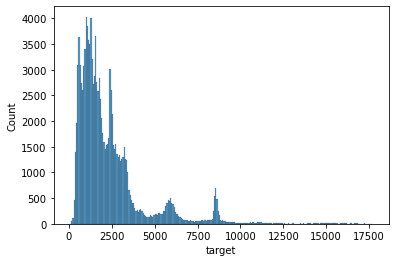

In [16]:
sns.histplot(eda_df.target)

<AxesSubplot:xlabel='target', ylabel='Count'>

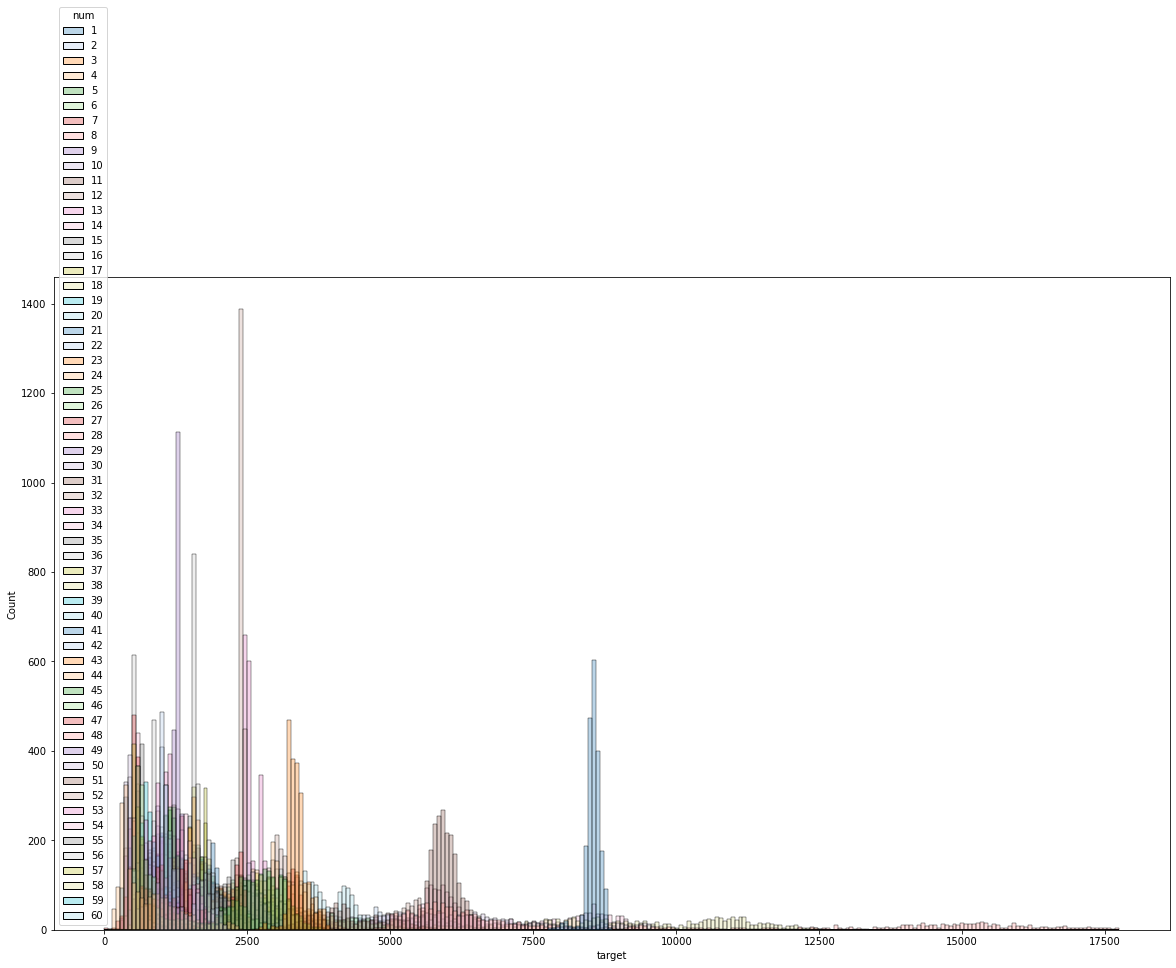

In [17]:
fig = plt.figure(figsize = (20, 12))
sns.histplot(data=eda_df, x='target', hue = 'num', alpha = 0.3, palette = 'tab20')

### 3-2. energy usage of each building in relation to datetime

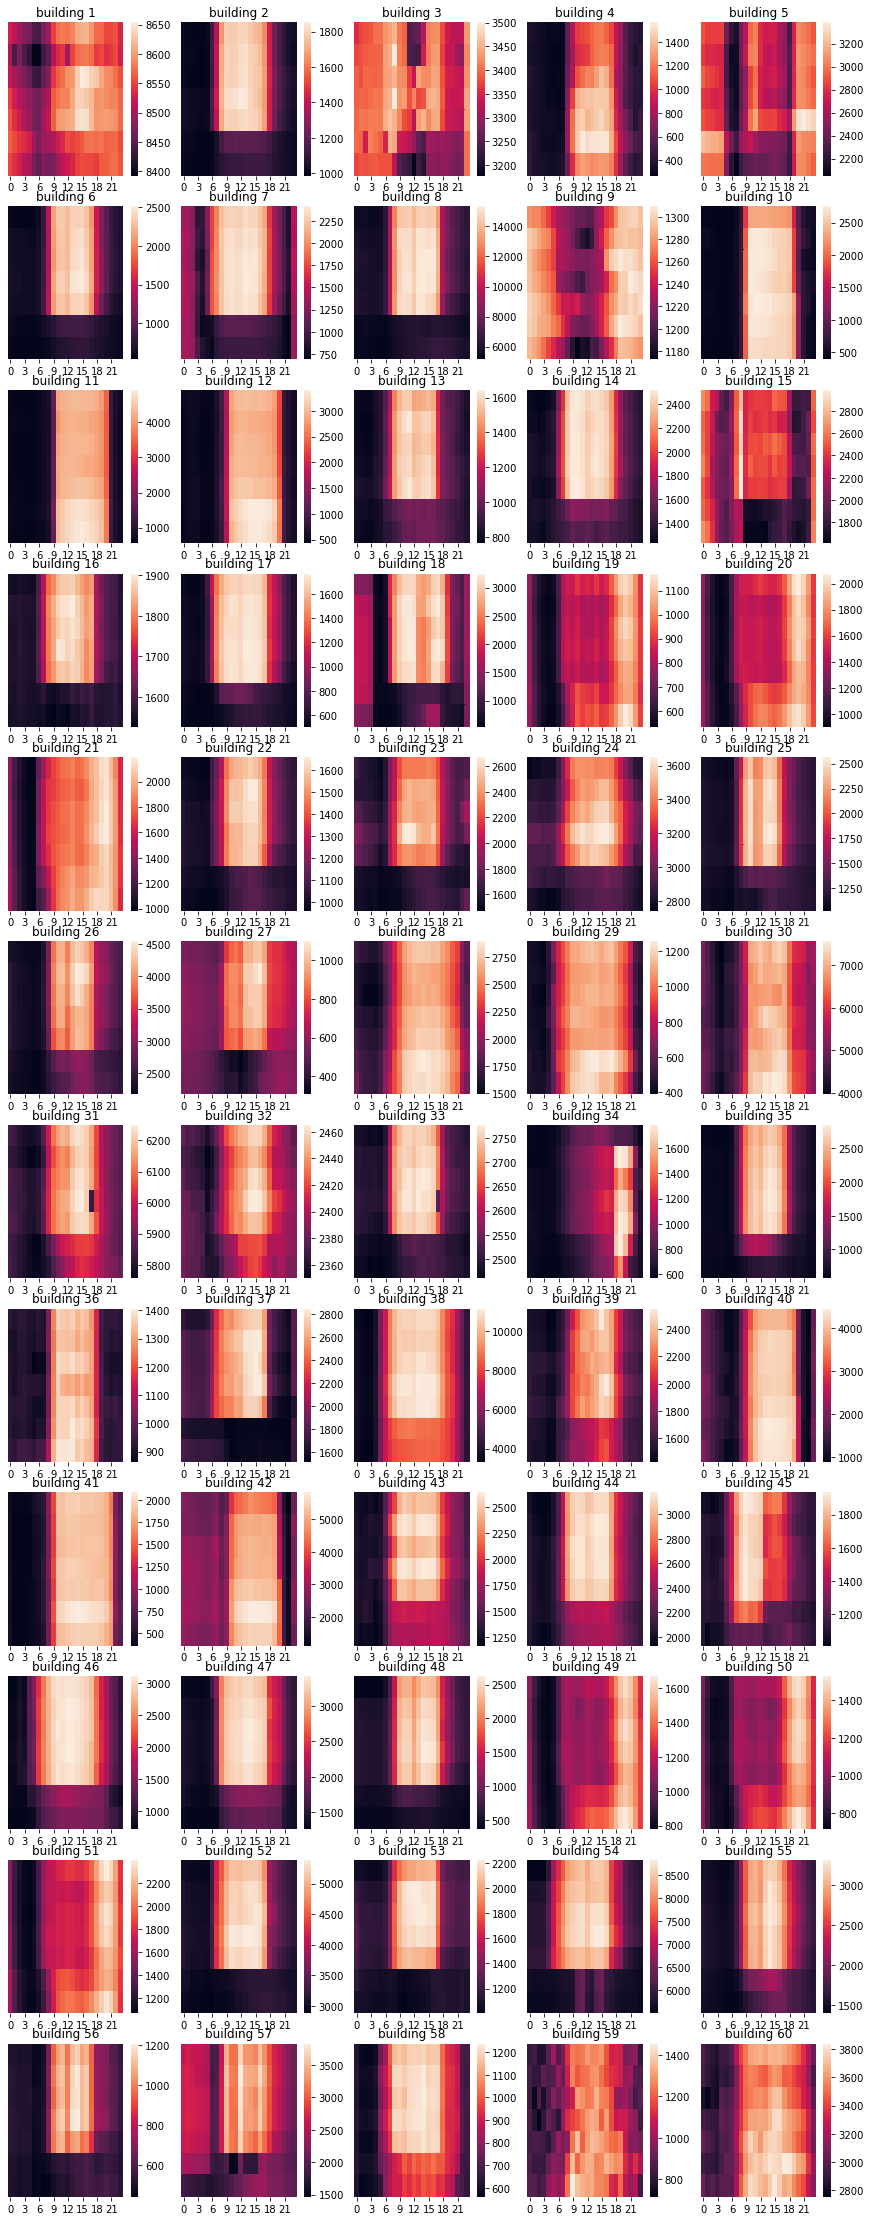

In [18]:
# energy usage of each building ~ weekday, hour
fig = plt.figure(figsize = (15, 40))
for num in eda_df['num'].unique():
    df = eda_df[eda_df.num == num]
    df = df.groupby(['weekday', 'hour'])['target'].mean().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(12, 5, num)
    sns.heatmap(df)
    plt.title(f'building {num}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

<AxesSubplot:xlabel='datetime', ylabel='target'>

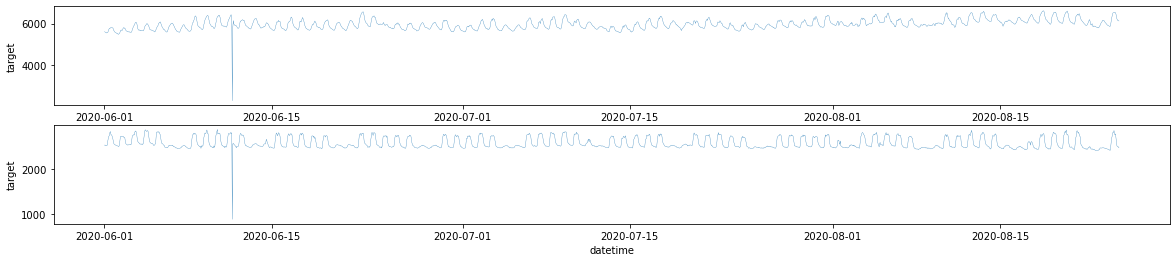

In [19]:
num_31 = eda_df[eda_df.num == 31]
num_33 = eda_df[eda_df.num == 33]

fig = plt.figure(figsize = (20, 4))
plt.subplot(211)
sns.lineplot(data = num_31, x = 'datetime', y = 'target', linewidth = 0.3)
plt.subplot(212)
sns.lineplot(data = num_33, x = 'datetime', y = 'target', linewidth = 0.3)

In [20]:
print(num_31.loc[num_31.target < 4000, 'datetime'])
print(num_33.loc[num_33.target < 2000, 'datetime'])

61457   2020-06-11 17:00:00
Name: datetime, dtype: datetime64[ns]
65537   2020-06-11 17:00:00
Name: datetime, dtype: datetime64[ns]


In [21]:
# 건물을 기준으로 하는 data frame 생성
by_weekday = eda_df.groupby(['num','weekday'])['target'].median().reset_index().pivot('num','weekday','target').reset_index()
by_hour = eda_df.groupby(['num','hour'])['target'].median().reset_index().pivot('num','hour','target').reset_index().drop('num', axis = 1)
df = pd.concat([by_weekday, by_hour], axis= 1)
columns = ['num'] + ['day'+str(i) for i in range(7)] + ['hour'+str(i) for i in range(24)]
df.columns = columns

In [22]:
# '전력사용량'이 아닌 '요일과 시간대에 따른 전력 사용량의 경향성'에 따라서만 군집화 할 것이므로, 특수한 scaling이 필요함
# standard scaling
for i in range(len(df)):
    # 요일 별 전력 중앙값에 대해 scaling
    df.iloc[i,1:8] = (df.iloc[i,1:8] - df.iloc[i,1:8].mean())/df.iloc[i,1:8].std()
    # 시간대별 전력 중앙값에 대해 scaling
    df.iloc[i,8:] = (df.iloc[i,8:] - df.iloc[i,8:].mean())/df.iloc[i,8:].std()

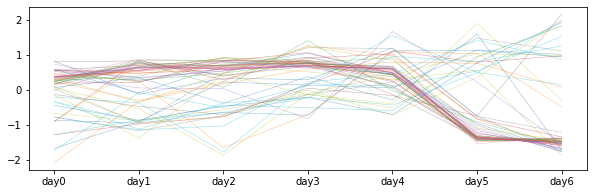

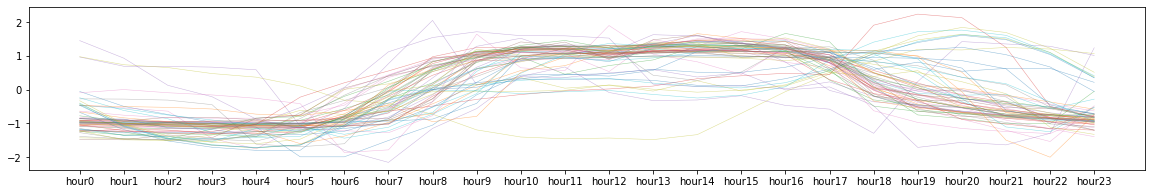

In [23]:
# visualization
fig = plt.figure(figsize = (10,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
fig = plt.figure(figsize = (20,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 8:], alpha = 0.5, linewidth = 0.5)

### K-means clusterting

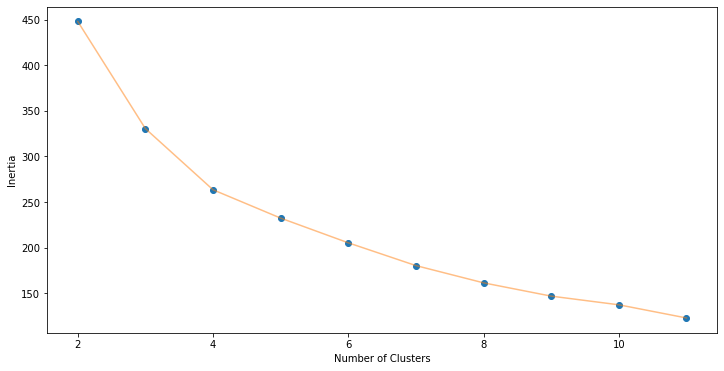

In [24]:
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], df.iloc[:,1:])

In [25]:
kmeans = KMeans(n_clusters=4, random_state = 2)
km_cluster = kmeans.fit_predict(df.iloc[:,1:])

In [26]:
df_clust = df.copy()
df_clust['km_cluster'] = km_cluster

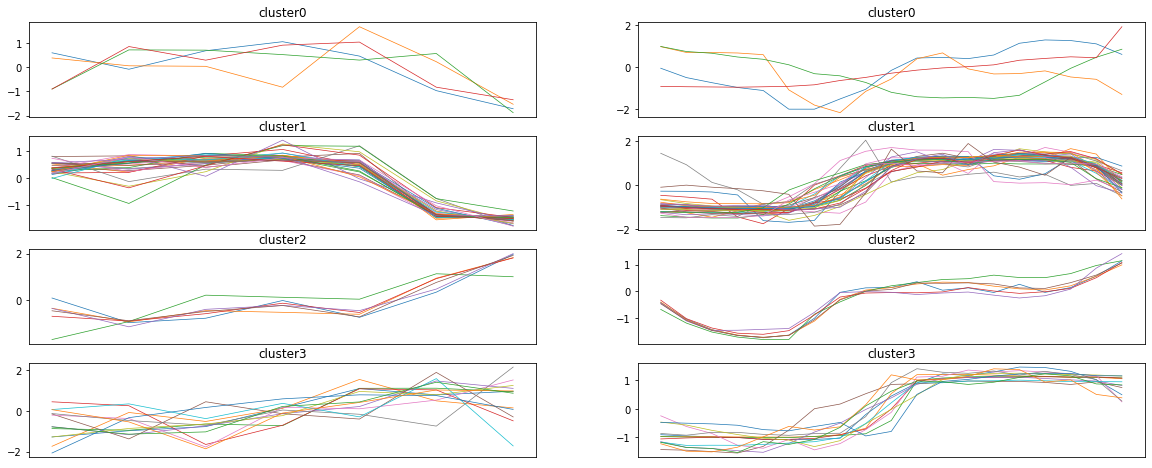

In [27]:
# visualizing result of kmeans clustering
n_c = len(np.unique(df_clust.km_cluster)) 

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = df_clust[df_clust.km_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

In [28]:
eda_df = eda_df.merge(df_clust[['num','km_cluster']], on = 'num', how = 'left')

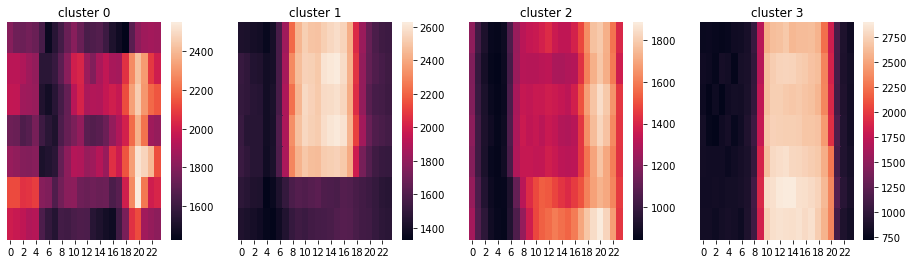

In [29]:
fig = plt.figure(figsize = (20, 4))
for c in range(4):
    temp = eda_df[eda_df.km_cluster == c]
    temp = temp.groupby(['weekday', 'hour'])['target'].median().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(1, 5, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

- cluster 0 : 야간과 주간 전력소모 차이는 뚜렷하지만, 평일 주말 관계없이 전력소모가 일정하거나 주말 전력소요가 조금 더 높은 건물(식당, 상점, 카페)
- cluster 1 : 출근 전 시간대에 전력소모가 매우 낮고, 저녁이 될 수록 전력소모가 커짐(산업시설?)
- cluster 2 : 평일보다 주말에 전력소모가 크고, 낮보다 밤에 전력소모가 큰 건물(유흥시설, 주점)
- cluster 3 : 평일 주간에 전력소모가 크고, 평일야간이나 주말에는 전력소모가 작은 건물(사무실, 학교)

In [30]:
# dictionary mapping cluster and building
match = df_clust[['num','km_cluster']]
clust_to_num = {0:[],1:[],2:[],3:[]}
for i in range(60):
    c = match.iloc[i,1]
    clust_to_num[c].append(i+1)

### Cluster Analysis

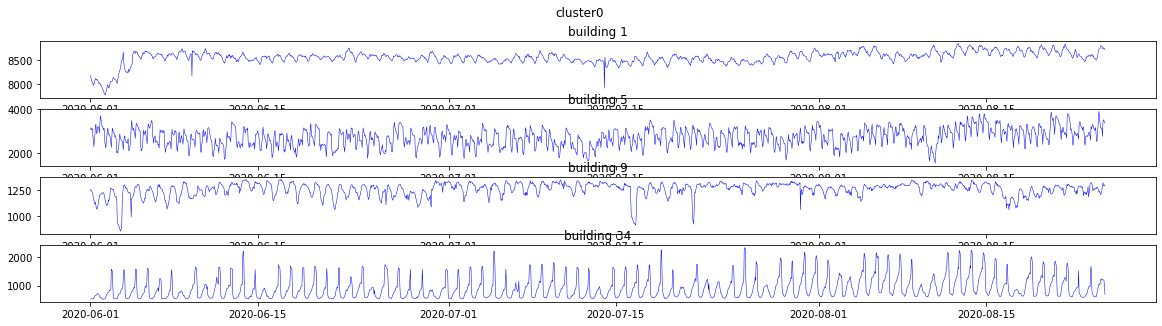

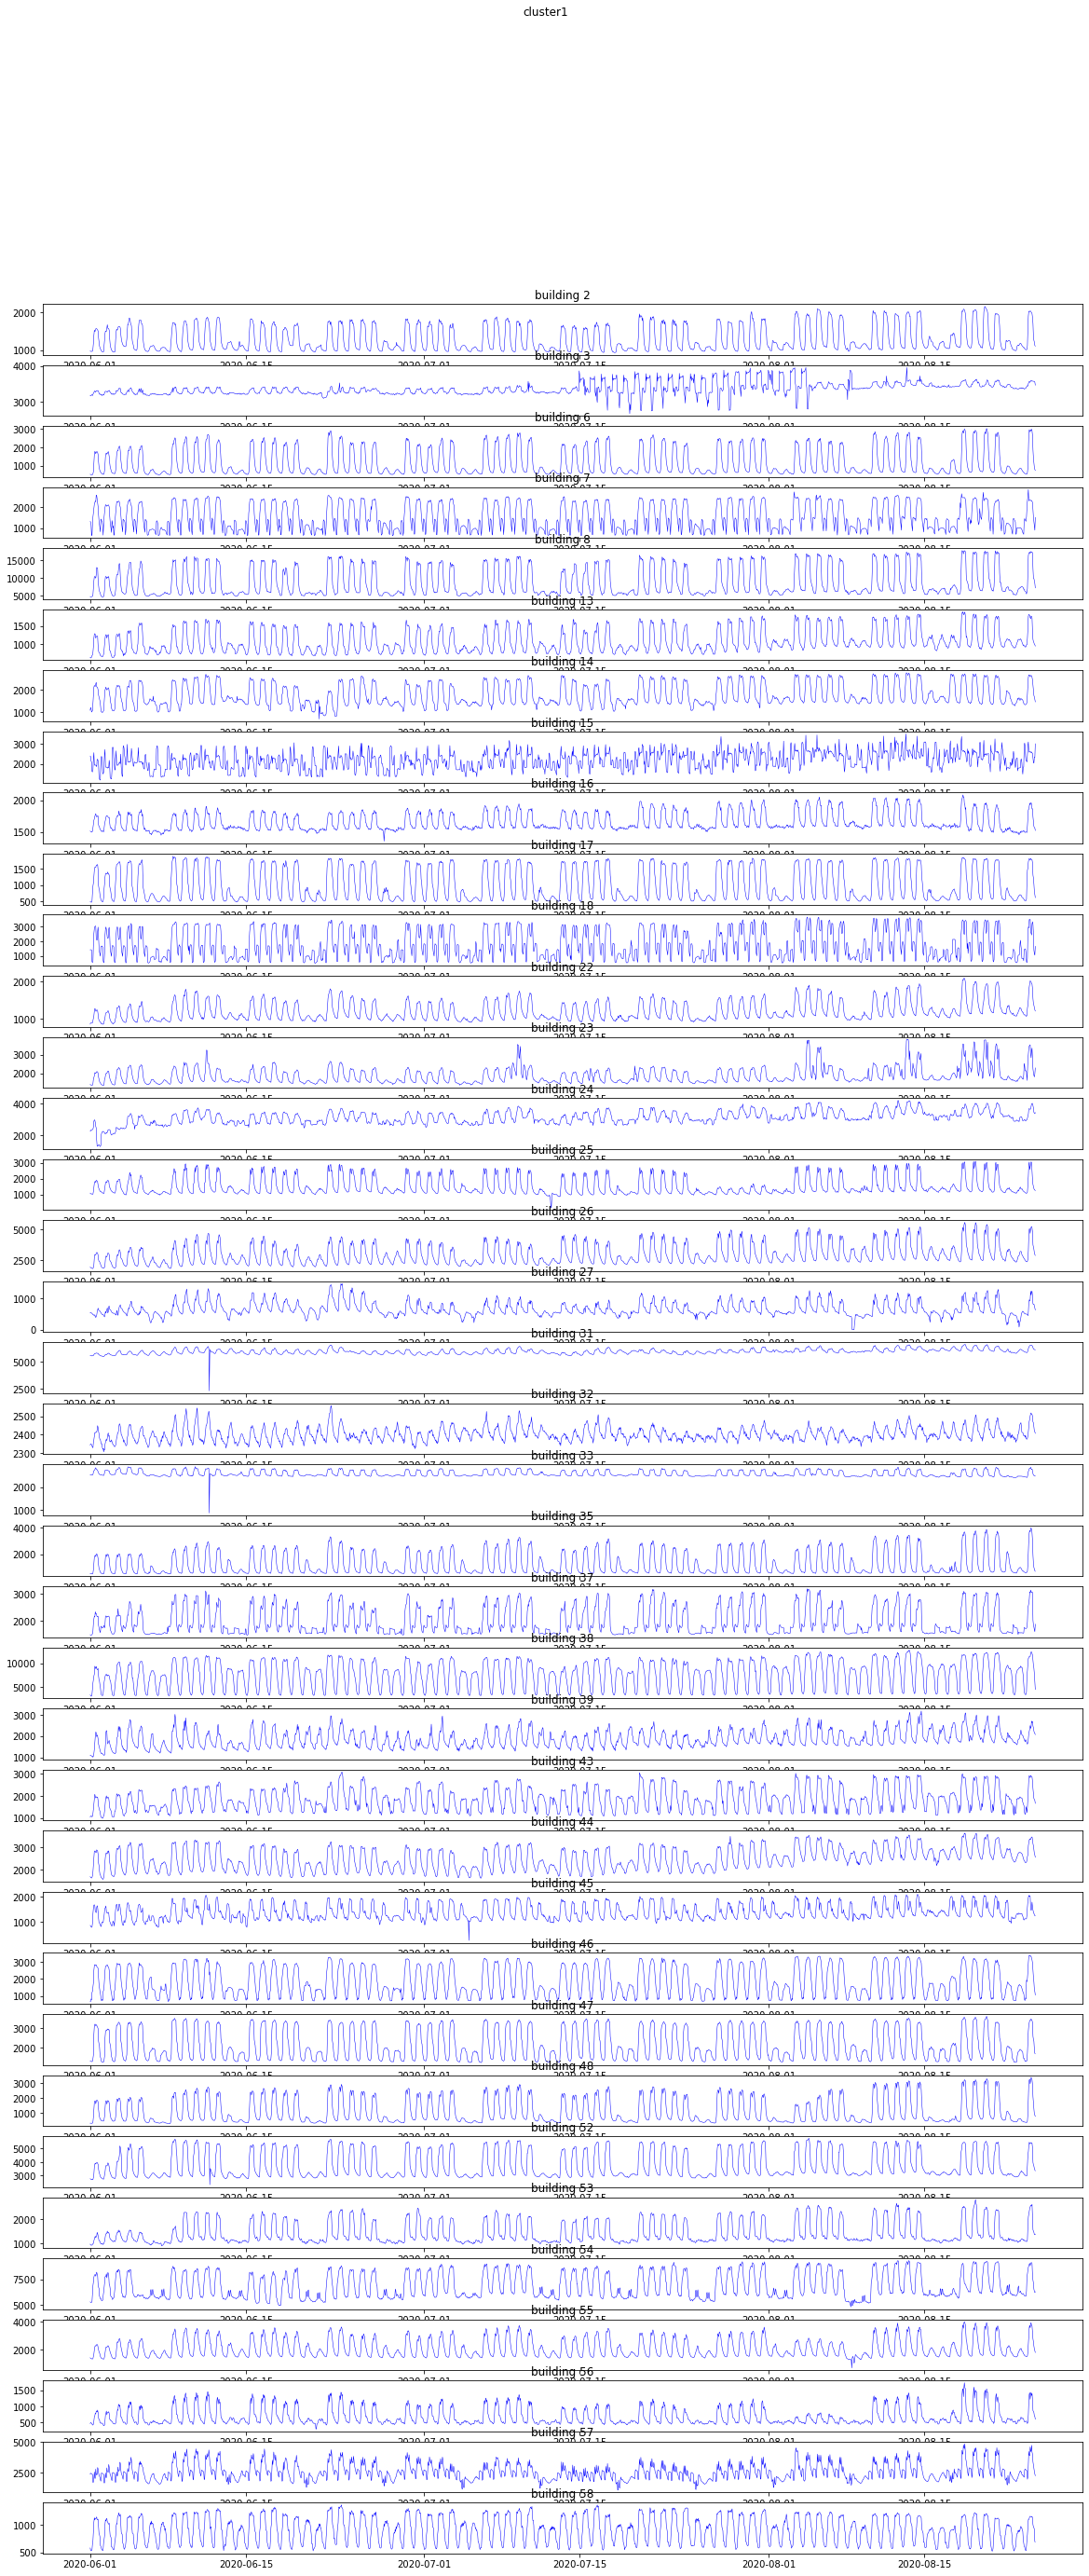

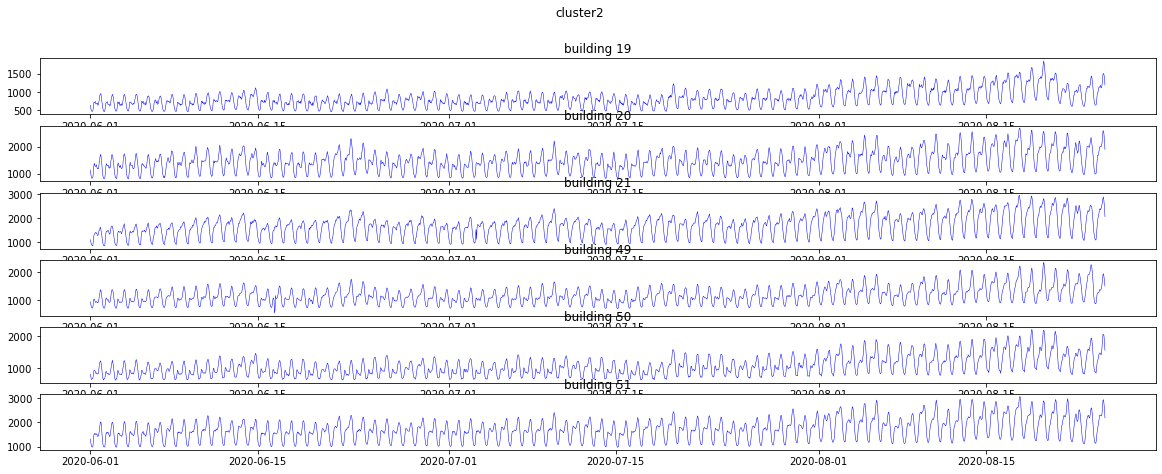

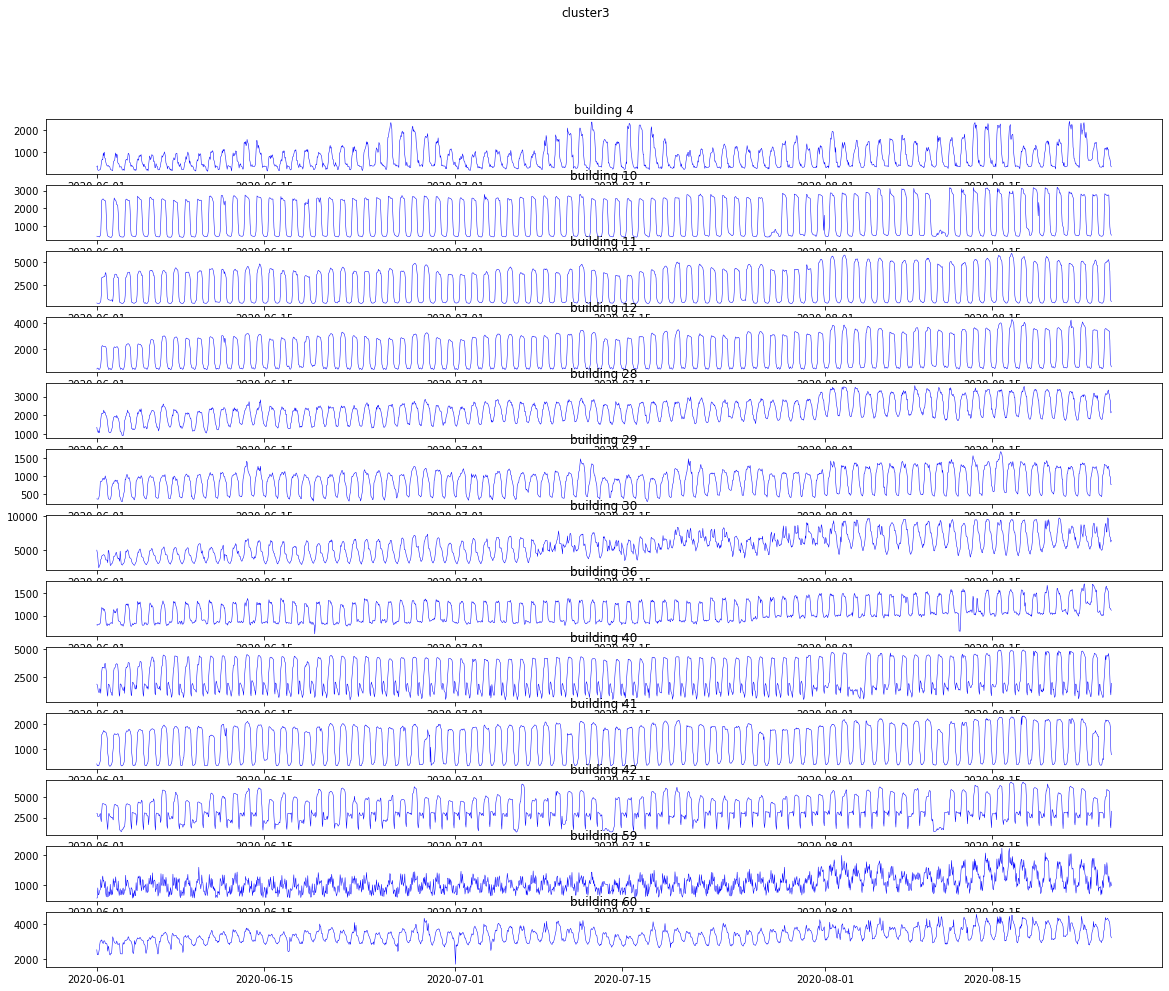

In [31]:
# linplot(energy usage of each building ~ cluster, datetime)
for c in range(4):
    temp_1 = eda_df[eda_df.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (20, 1.2*n_nums))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        plt.subplot(n_nums,1, i+1)
        sns.lineplot(data = temp_2, x= 'datetime', y = 'target', linewidth = 0.5, color = 'blue')
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')

lineplot을 통해, 요일과 시간보다는 날짜에 초점을 맞추어 분석해보겠습니다.

- cluster 0 : 낮과 밤에 따라서 전력사용량이 증가 감소를 반복하는 경향성이 보입니다.
건물 4의 경우, 불분명한 원인으로 인해 특정 주기에 낮 전력 소요가 높아지는 현상이 보입니다.
많은 건물들에서 시간이 지남에 따라 전력소요가 증가하는 양상을 보입니다.(냉방으로 인한 것으로 보입니다.)

- cluster 1 : 한 군집으로 분류되긴 했으나, 공통적인 특징이 보이지 않습니다.
건물 1의 경우, 초반 3일동안 전력소요가 낮게 나타납니다.

- cluster 2 : 공통적으로 더위가 심해질수록 전력사용량이 점진적으로 증가합니다.
- cluster 3 : 평일과 주말이 구분되는 양상을 보입니다. 이 군집에 속한 건물들은 공통적으로 대체공휴일(8.17)에도 전력소요가 낮게 나타납니다. 

사무실과 학교 같은 일터 라는 추측에 확신을 가질 수 있습니다.
건물 3의 경우, 7.15-8.4 일동안 비정상적인 전력소요 양상이 보입니다.
건물 23의 경우, 8.4일부터 전력소요의 양상이 바뀝니다.
이 군집에 속한 대부분의 건물들에서, 점심시간(11-12시)에 전력소요가 소폭 감소하는 모습도 보입니다.


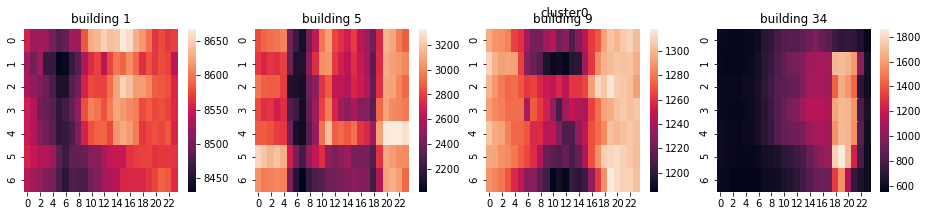

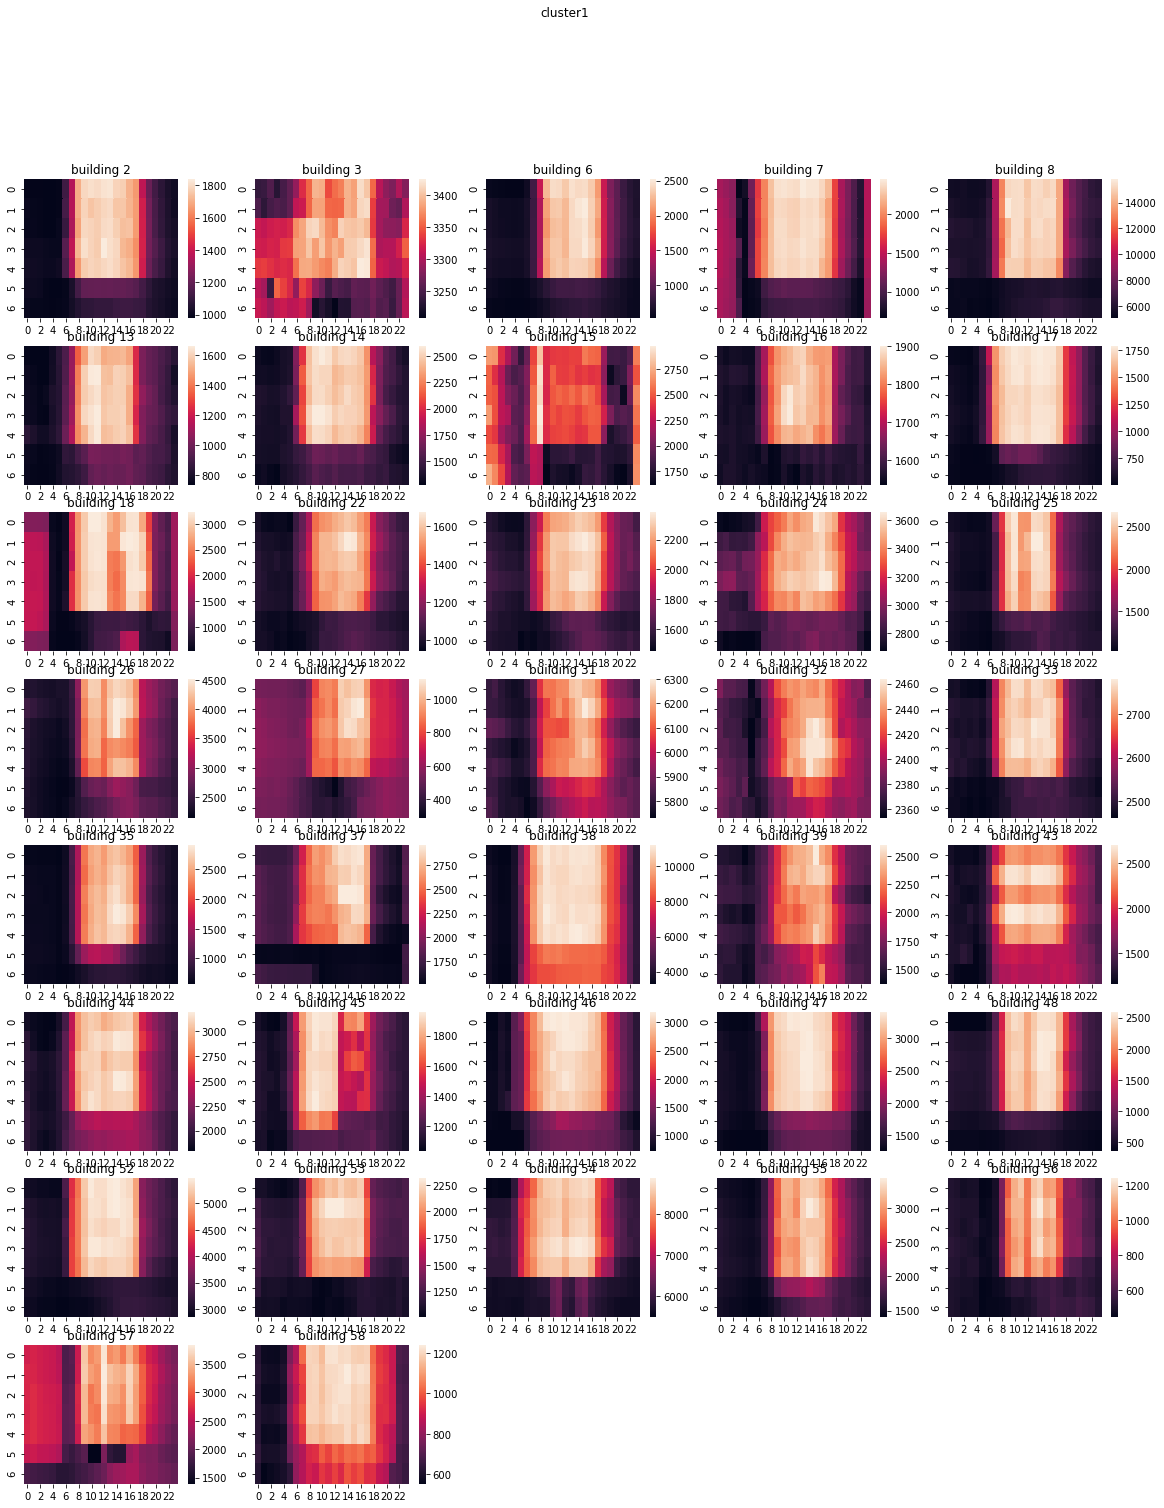

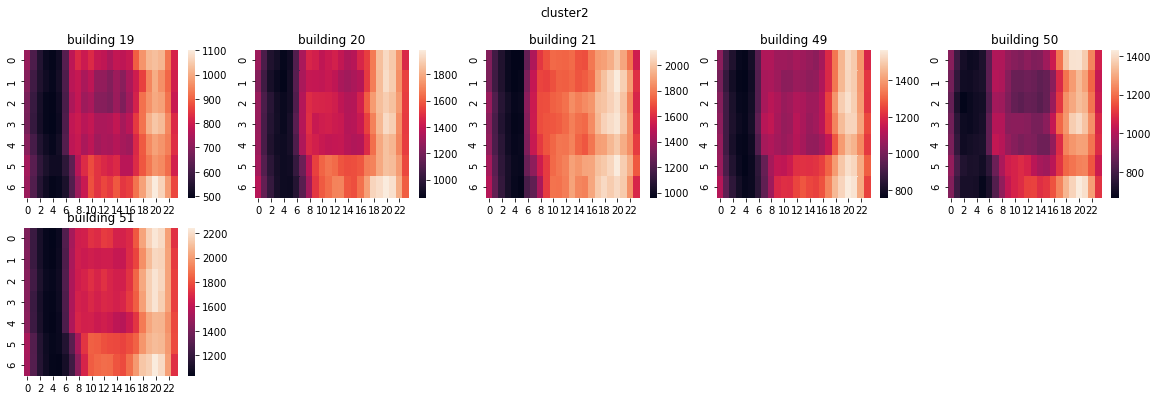

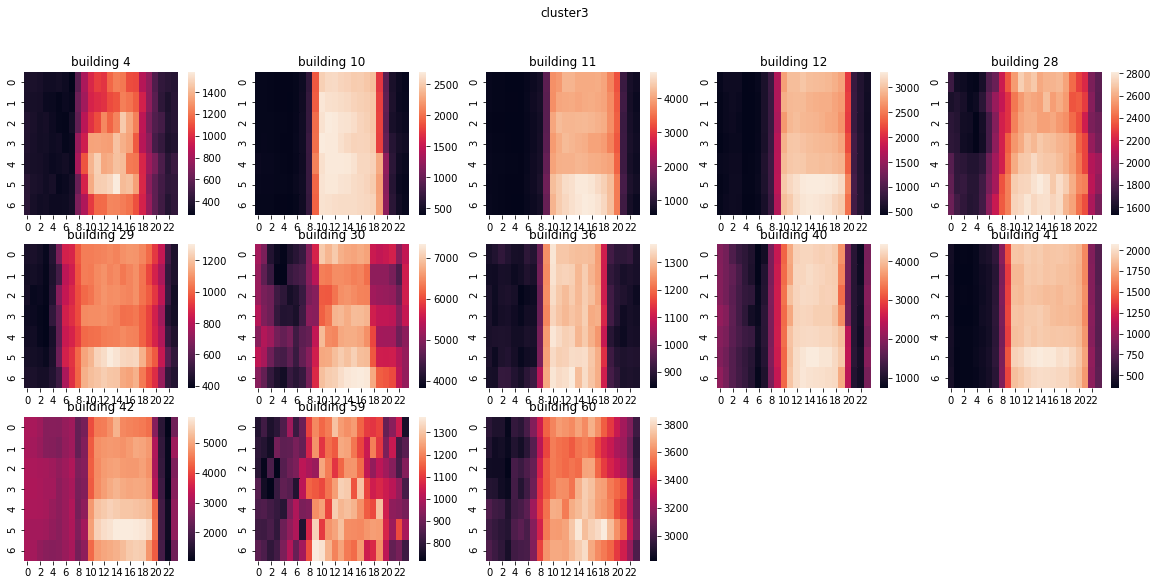

In [32]:
# heatmap(energy usage of each building ~ cluster, weekday, hour)
for c in range(4):
    temp_1 = eda_df[eda_df.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (20, 3*(n_nums//5 + 1)))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        temp_2 = temp_2.groupby(['weekday', 'hour'])['target'].median().reset_index().pivot('weekday', 'hour', 'target')
        plt.subplot(n_nums//5+1,5, i+1)
        sns.heatmap(temp_2)
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')

## 3-3. Energy usage of each building in relation to weather

### Temperture

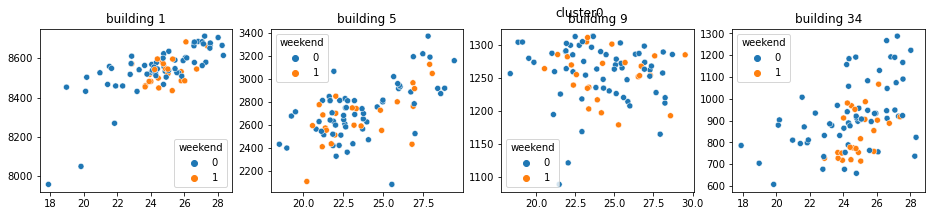

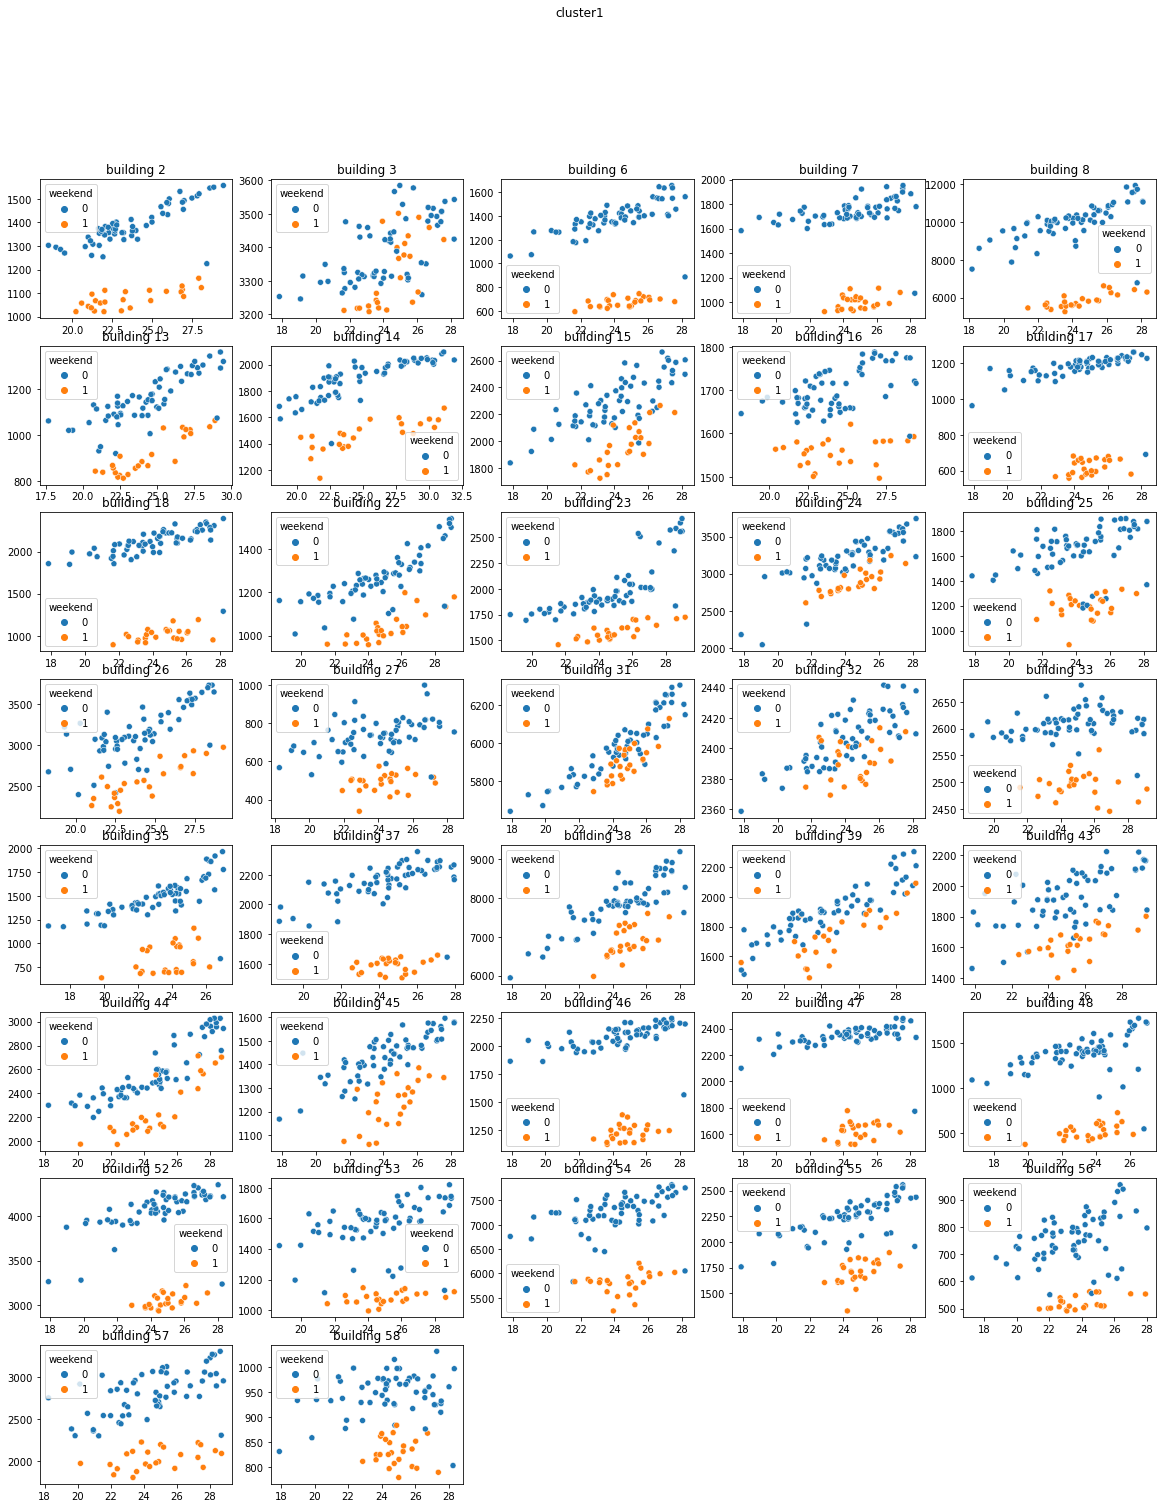

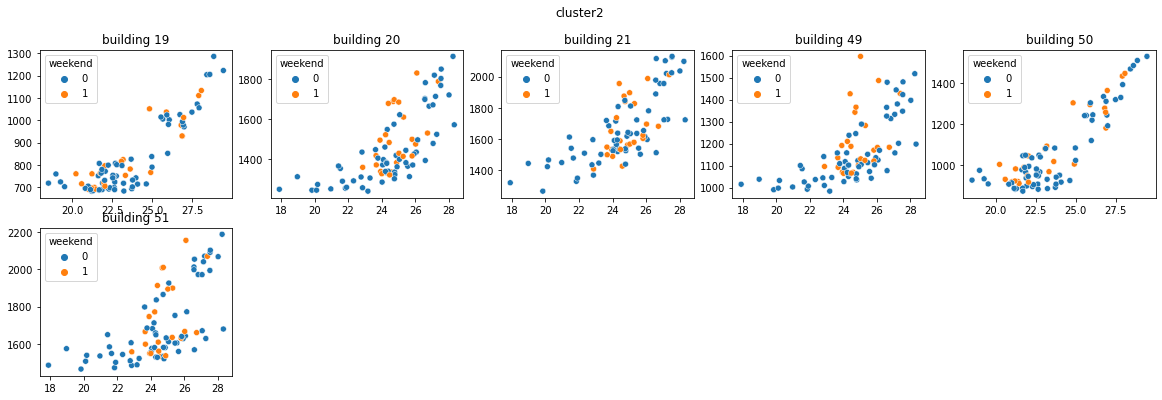

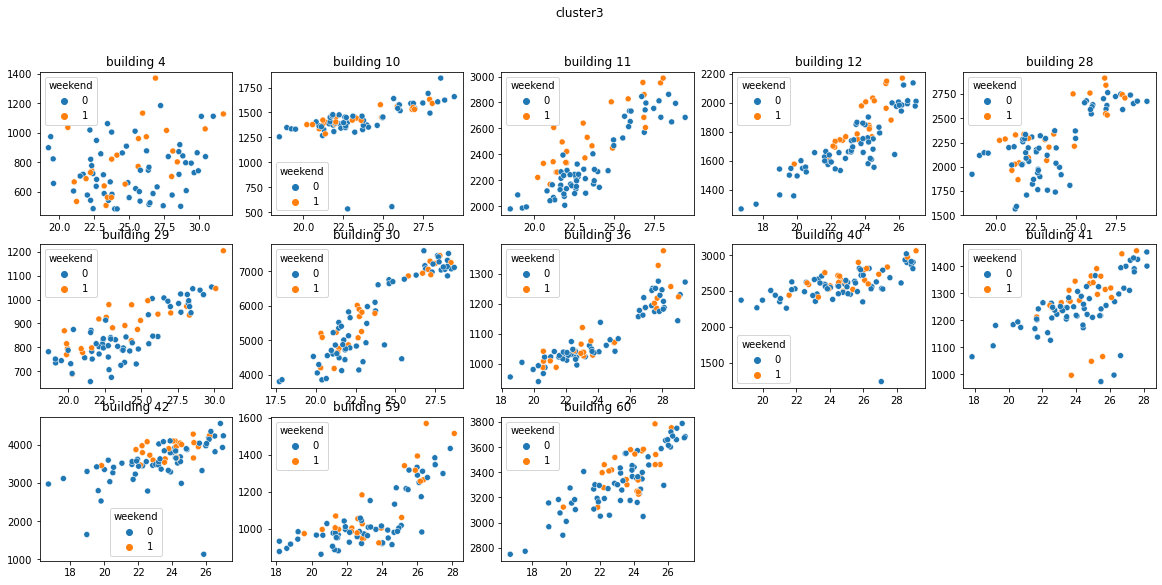

In [33]:
# 날짜별로 일평균 기온과 일평균 전력 사용량의 상관관계 파악
for c in range(4):
    temp_1 = eda_df[eda_df.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (20, 3*(n_nums//5 + 1)))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        temp_2 = temp_2.groupby(['num','date','weekend'])[['target','temp']].mean().reset_index()
        plt.subplot(n_nums//5+1,5, i+1)
        sns.scatterplot(data = temp_2, x='temp', y='target', hue= 'weekend')
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')

온도상승에 따라 전력소요가 커진다는 것은, 냉방시설 전력소요가 중요한 건물임을 의미합니다.

- cluster 0과 2에 속하는 건물들은 building 4를 제외하고는 기온상승에 따라 전력소요가 커집니다.(소비공간일 가능성이 높습니다.)
- cluster 3에 속하는 건물들에서도 기온상승에 따라 전력소요가 커지는 경향성이 약하게나마 보입니다.
- cluster 1에 속하는 건물들은 building 9를 제외하고는 기온상승에 따라 전력소요가 커지는 경향성이 약하게나마 보입니다.

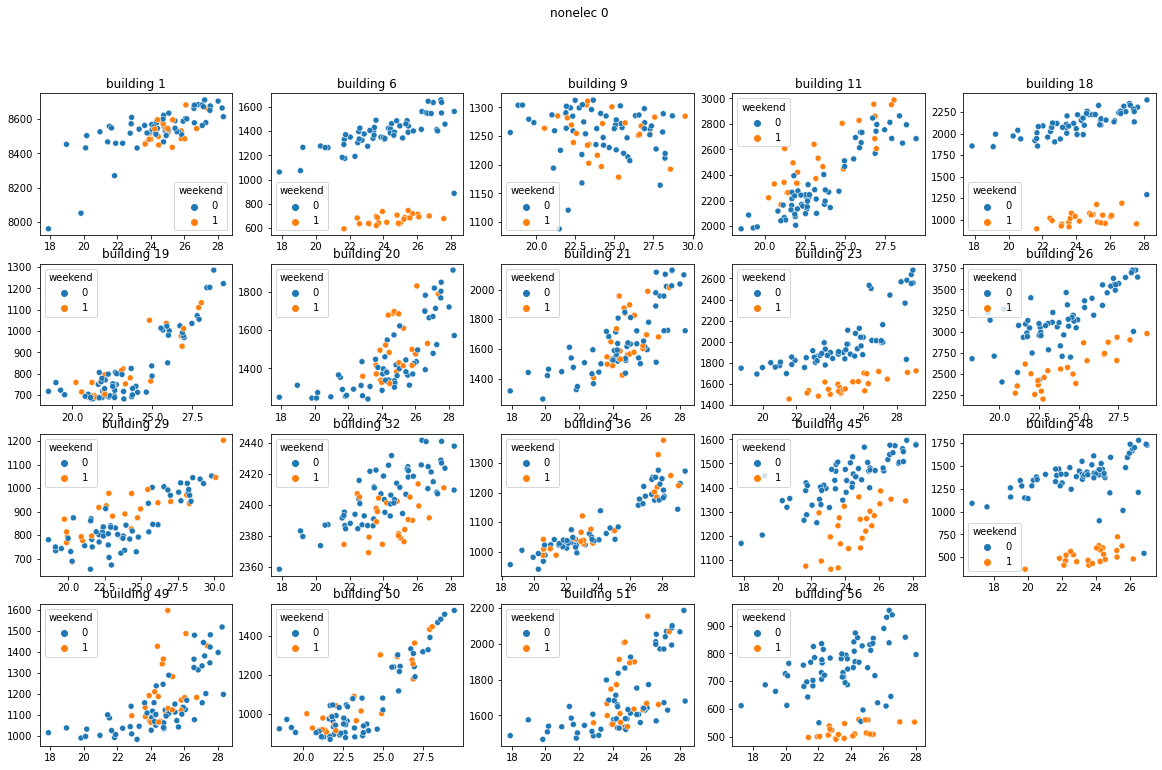

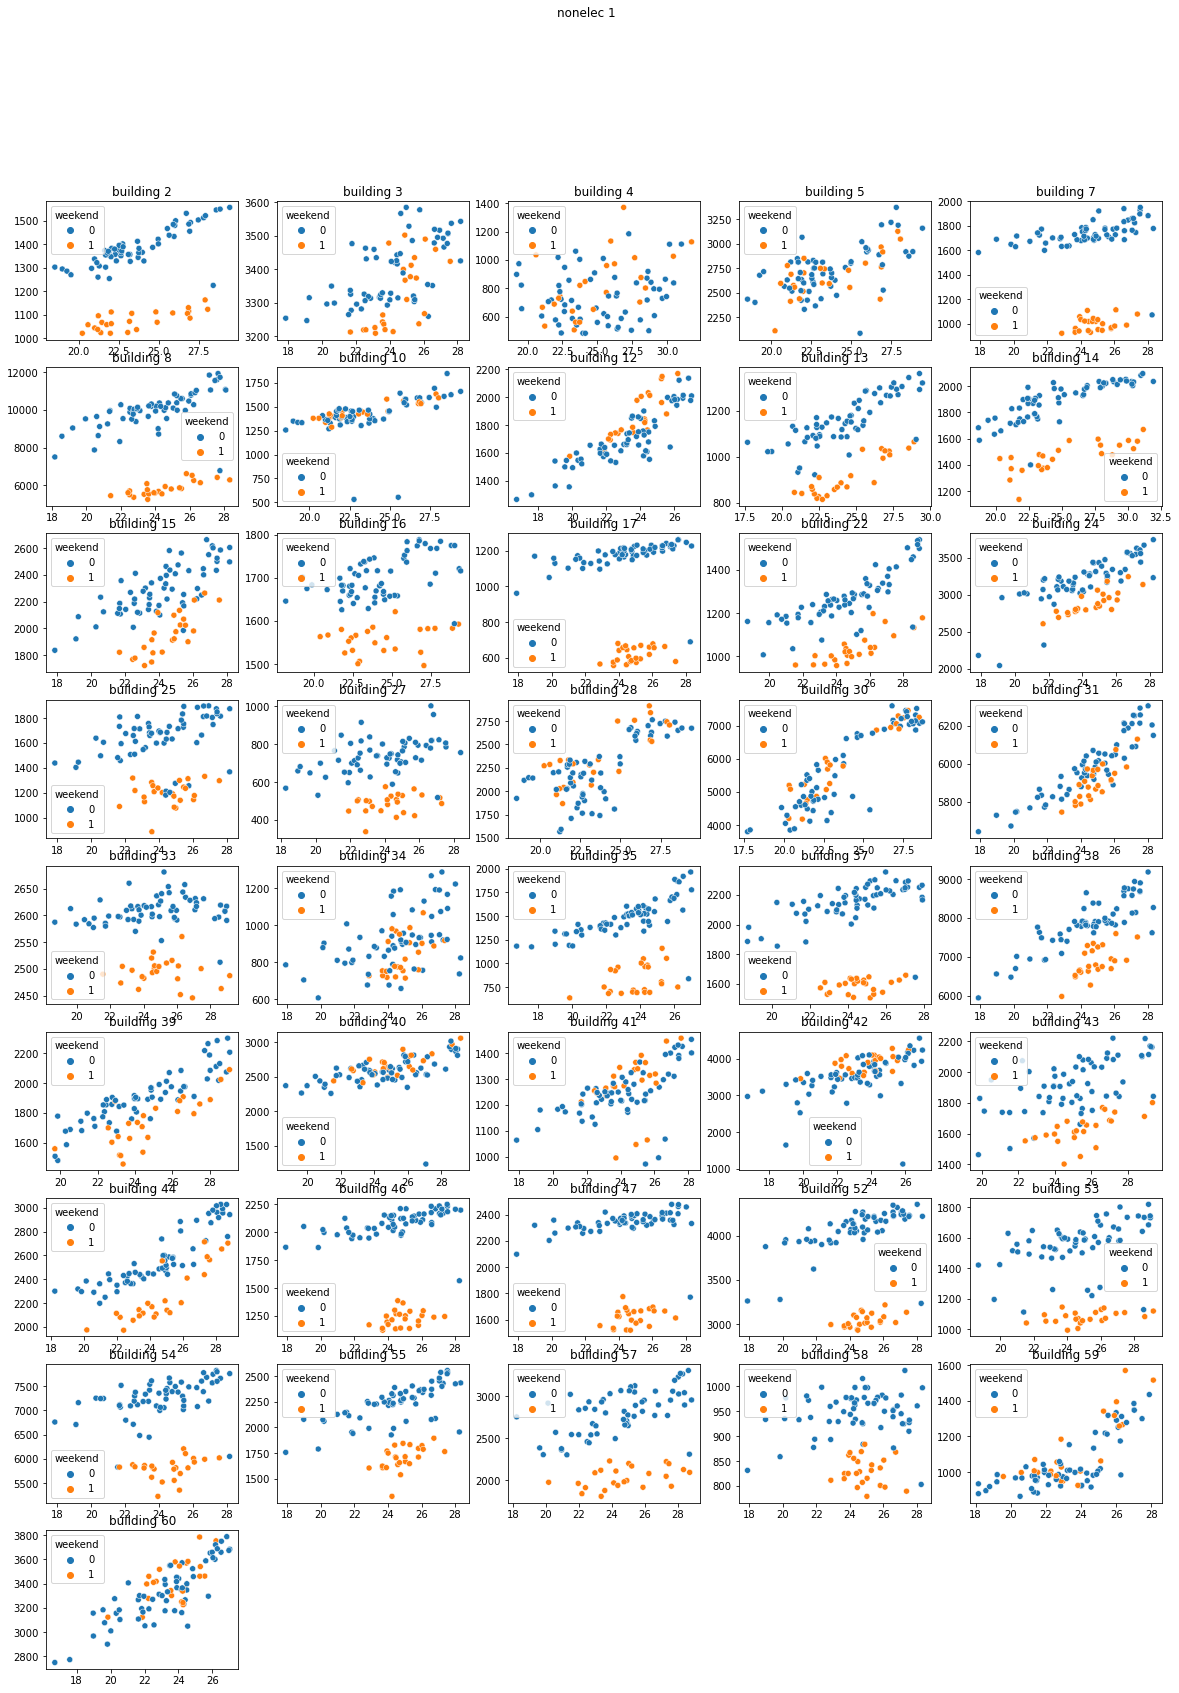

In [34]:
#비전기냉방보유여부에 따른 기온~전력소요 상관관계
for c in range(2):
    temp_1 = eda_df[eda_df.nonelec == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (20, 3*(n_nums//5 + 1)))
    plt.suptitle(f'nonelec {c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        temp_2 = temp_2.groupby(['num','date','weekend'])[['target','temp']].mean().reset_index()
        plt.subplot(n_nums//5+1,5, i+1)
        sns.scatterplot(data = temp_2, x='temp', y='target', hue= 'weekend')
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')

비전기냉방시설이 있다고 해서, 기온 상승에도 불구하고 전력소요가 일정하게 유지되는 경향성은 보이지 않으므로

비전기냉방시설 보유 여부는 전력소요와 크게 관련이 없어 보입니다.

지금까지의 분석을 통해, 건물 cluster 0,2,3에서 일일 평균 기온이 일일 평균 전력 사용량에 영향을 준다는 점은 알 수 있었습니다.

하지만 기온(temperature) 변수는 설명력이 다소 부족합니다. 냉방 전력소요의 측면에서 보았을 때, 전력 사용량은 기온이 변함에 따라 즉각적으로 변화하진 않기 때문입니다.

냉방전력소요와 관련하여, CDH(cooling degree hour, 냉방도일) 이라는 개념을 조금 변형하여 적용해 보았습니다. 냉방 기준온도(26도)보다 높은 시점에서 해당 시점의 온도와 기준온도의 차를 적산하여 구할 수 있습니다. 이렇게 구해진 CDH 라는 변수는, 기온보다 냉방 수요에 대한 설명력이 높습니다. 결과를 시각화 해 보겠습니다.

In [35]:
# CDH feature추가
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if 1 < 11:
            ys.append(np.sum(xs[:i+1]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1, 61, 1):
    temp = eda_df[eda_df['num'] == num]
    cdh = CDH(temp['temp'].values)
    cdhs = np.concatenate([cdhs, cdh])
eda_df['CDH'] = cdhs

In [36]:
#eda_df.head(10)

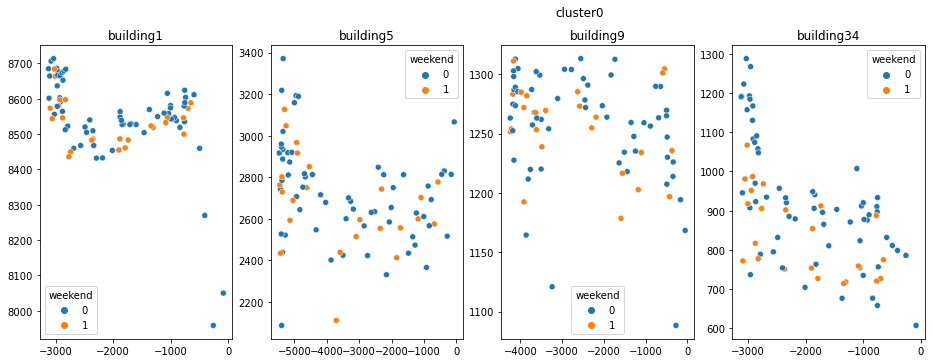

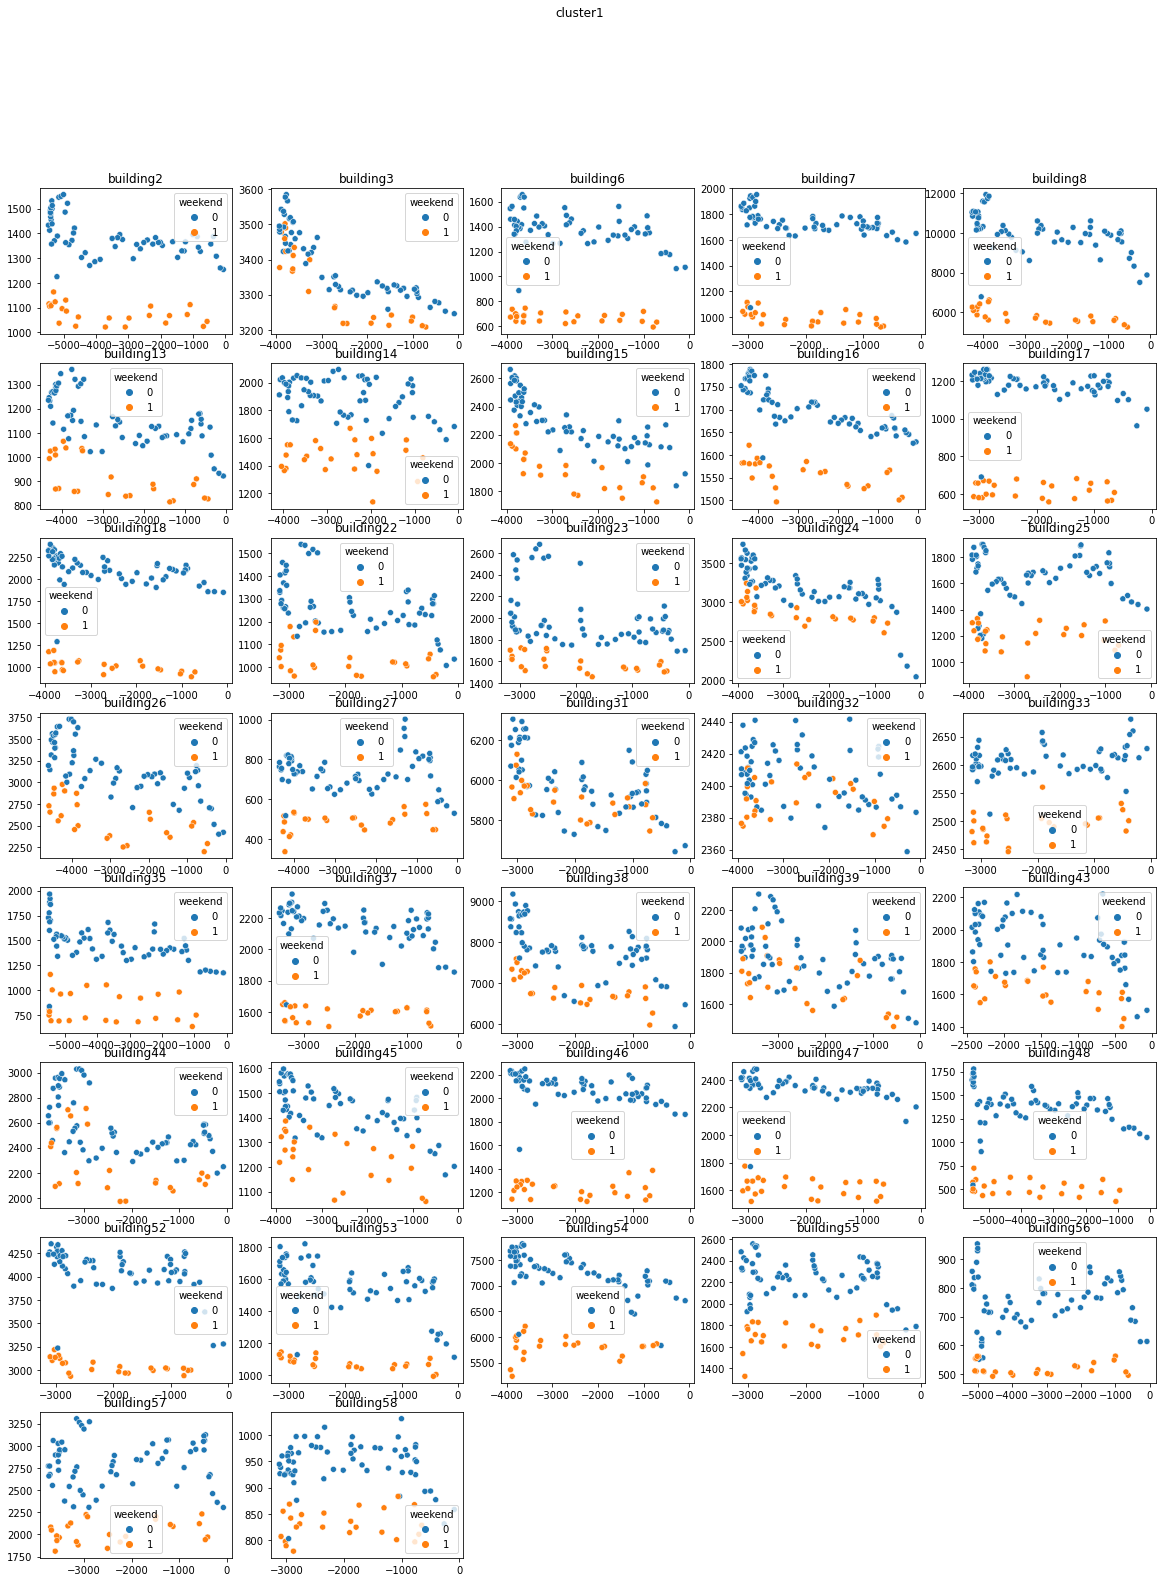

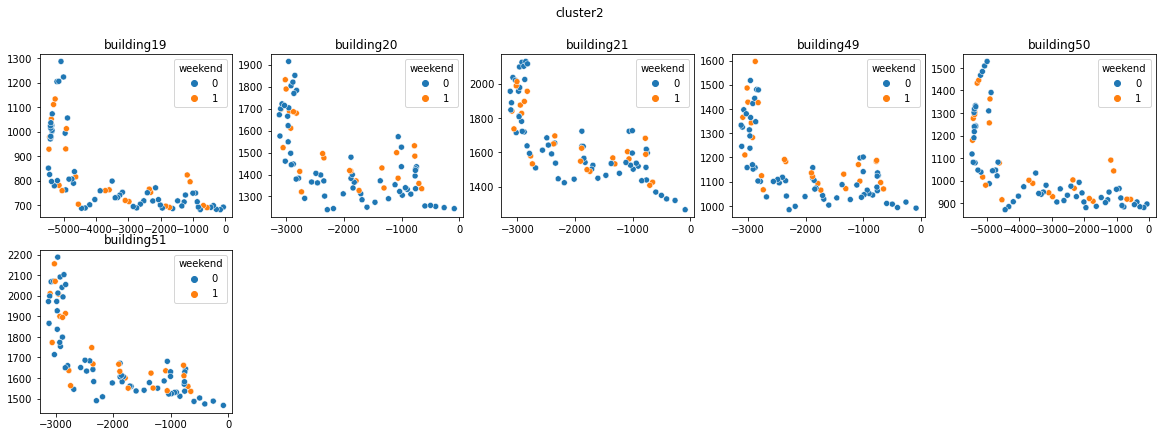

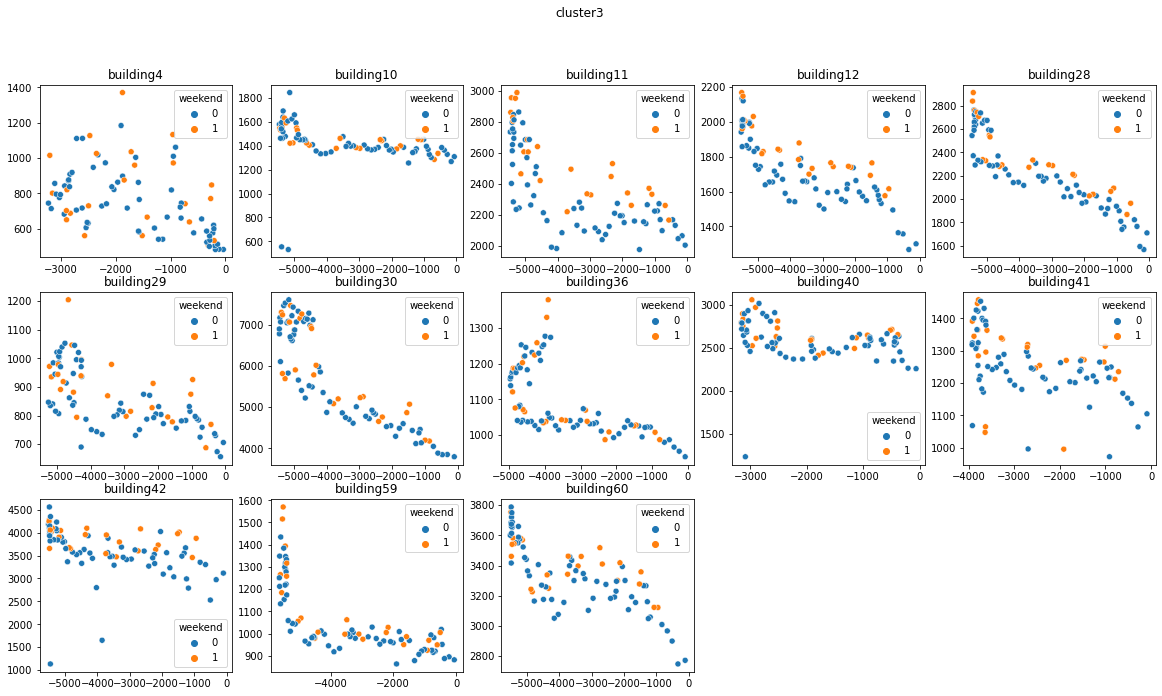

In [37]:
for c in range(4):
    temp_1 = eda_df[eda_df.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize=(20, 3*(n_nums/5+1)))
    plt.suptitle(f'cluster{c}')
    
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        temp_2_tg = temp_2.groupby(['num','date','weekend'])[['target']].mean().reset_index()
        temp_2_cdh = temp_2.groupby(['num','date','weekend'])[['CDH']].mean().reset_index()
        temp_2 = temp_2_tg.merge(temp_2_cdh, on=['num','date','weekend'], how='left')
        plt.subplot(n_nums/5+1,5,i+1)
        sns.scatterplot(data=temp_2, x='CDH', y='target', hue='weekend')
        plt.title(f'building{num}')
        plt.ylabel('')
        plt.xlabel('')

- cluster 0,2,3에 속한 건물들에서는 일평균 CDH와 일평균 전력소요 간에 유의미한 관계가 보입니다.

다음으로 확인해 볼것으로 '불쾌지수' 입니다. 불쾌지수를 계산하여, 쾌적/다소불쾌/불쾌/매우 불쾌 4개의 카테고리로 나눈 뒤, 불쾌지수 정도에 따른 전력사용량 분포를 파악해 보겠습니다.

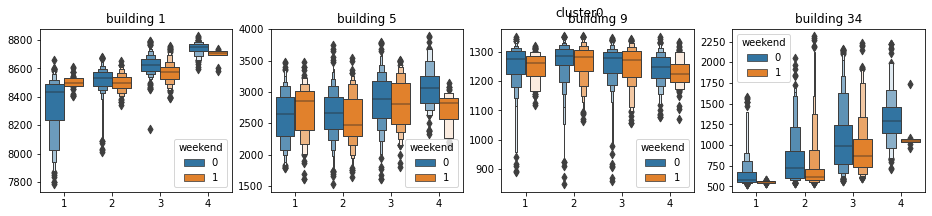

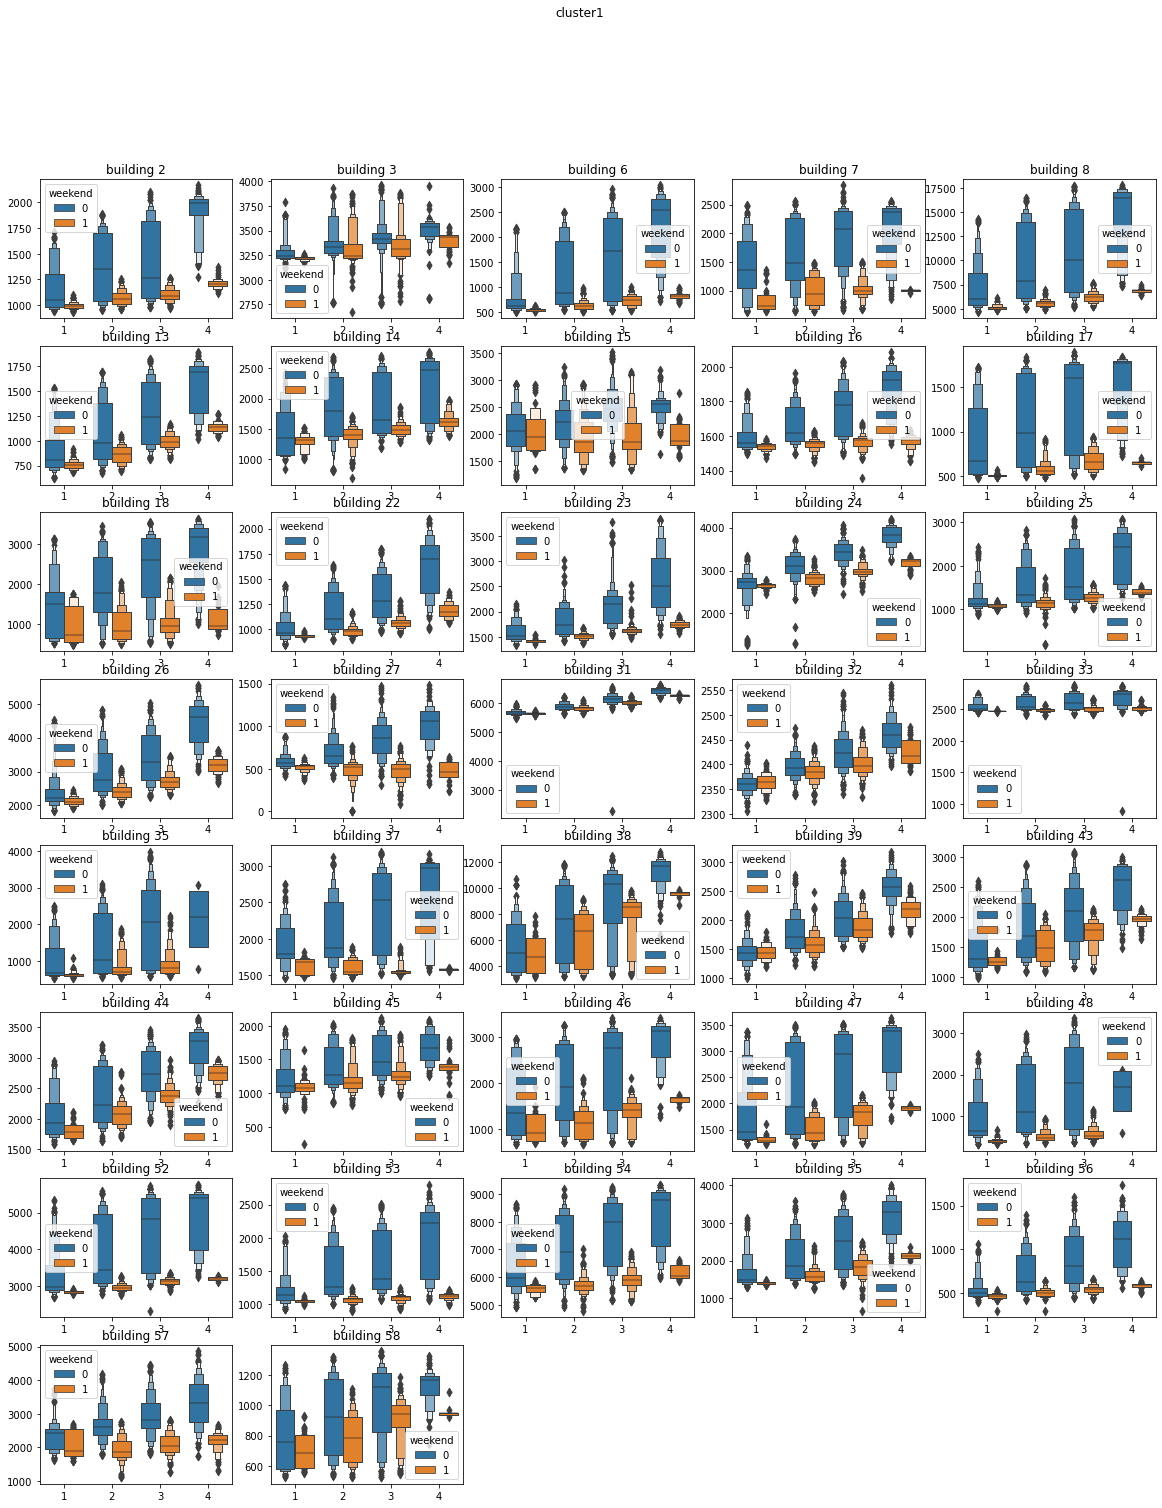

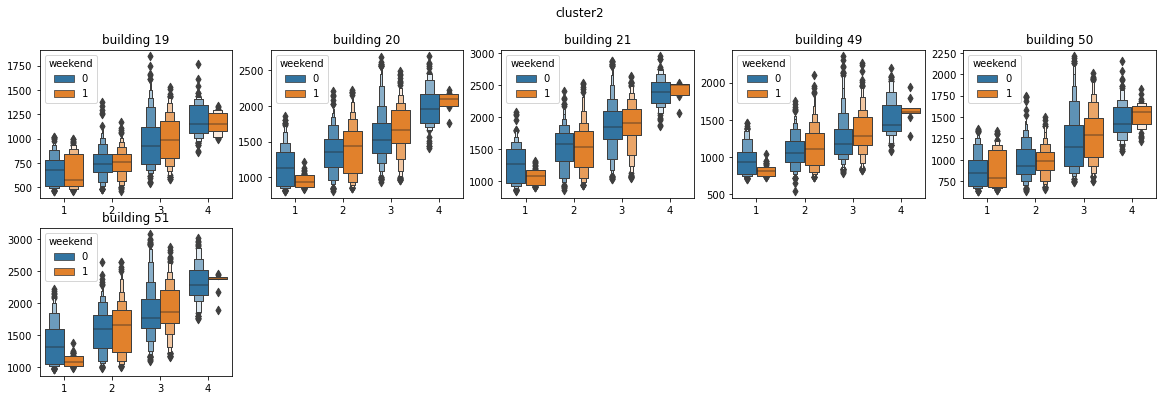

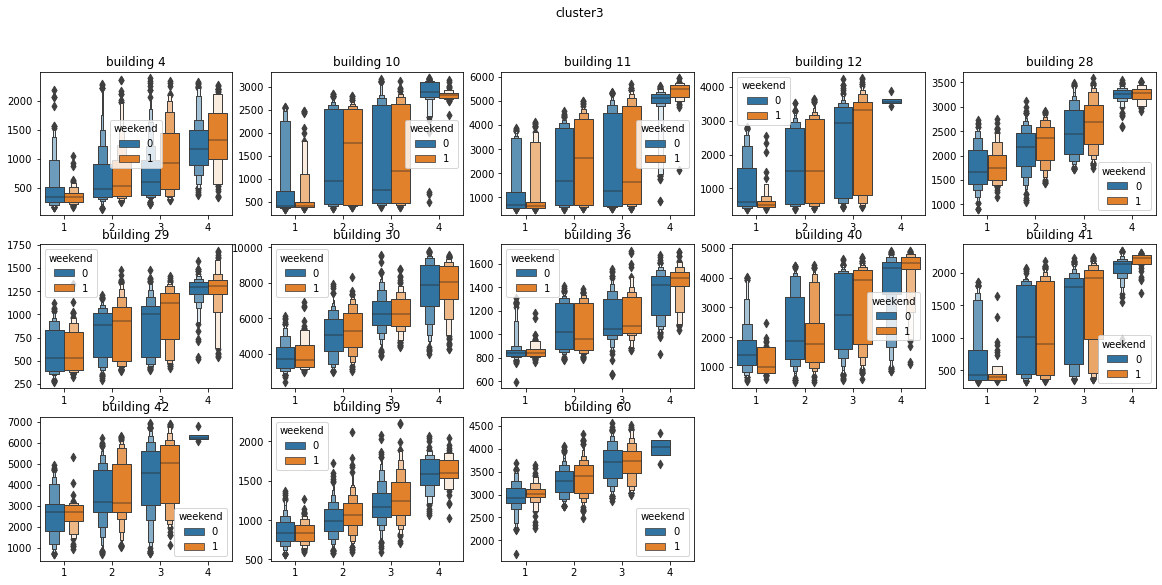

In [38]:
eda_df['THI'] = 9/5*eda_df['temp'] - 0.55*(1-eda_df['hum']/100)*(9/5*eda_df['temp']-26)+32
eda_df['THI_cat'] = pd.cut(eda_df['THI'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])

for c in range(4):
    temp_1 = eda_df[eda_df.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (20, 3*(n_nums//5 + 1)))
    plt.suptitle(f'cluster{c}')
    
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        plt.subplot(n_nums//5+1,5, i+1)
        sns.boxenplot(data = temp_2, x='THI_cat', y='target', hue= 'weekend')
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')

- 건물 9를 제외하고는 불쾌지수에 따라 전력 소모가 증가하는 양상을 보입니다.
- 많은 건물에서 불쾌지수가 4(매우 불쾌)일 때, 전력 소모가 급증합니다.


전반적으로, temperature, THI(불쾌지수), CDH(냉방도일)의 평균값이 일일 에너지 사용량 평균치와 높은 상관관계를 보이고 있습니다. 지금까지의 시각화 결과, 기상 관련 변수들은 하루 동안의 에너지 증감 추세보다는 장기적인 추세를 잘 반영하므로, feature에 추가할 수 있습니다.

## 4. Data Preprocessing and Cross Validation

- mean_temp, mean_THI, mean_CDH, data_num 등의 일별 feature를 추가
- cluster 별로, working time boolean feature 추가, cluster0 의 경우 낮 시간대에, cluster2의 경우 밤시간대에 cluster3의 경우 평일 낮 시간대에 전력 사용량이 높에 나타나므로, 해당 시간대에 1의 값을 feature를 추가

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   num       122400 non-null  int64  
 1   datetime  122400 non-null  object 
 2   target    122400 non-null  float64
 3   temp      122400 non-null  float64
 4   wind      122400 non-null  float64
 5   hum       122400 non-null  float64
 6   rain      122400 non-null  float64
 7   sun       122400 non-null  float64
 8   nonelec   122400 non-null  float64
 9   solar     122400 non-null  float64
 10  time      122400 non-null  int64  
 11  weekday   122400 non-null  int64  
 12  weekend   122400 non-null  int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 12.1+ MB


In [56]:
# function for feature engineering
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

# data preprocessing function for testset
def train_preprocess(train):
    X_train = train.copy()
    X_train['datetime'] = pd.to_datetime(X_train['datetime'])
    X_train['hour'] = X_train['datetime'].dt.hour
    X_train['month'] = X_train['datetime'].dt.month
    X_train['day'] = X_train['datetime'].dt.day
    X_train['date'] = X_train['datetime'].dt.date
    X_train['weekday'] = X_train['datetime'].dt.weekday
    
    ## one hot encoding for weekday and hour
    X_train = pd.concat([X_train, pd.get_dummies(X_train['weekday'], prefix ='weekday')], axis=1)
    X_train = pd.concat([X_train, pd.get_dummies(X_train['hour'], prefix ='hour')], axis=1)
    ## daily minimum temperature
    X_train = X_train.merge(X_train.groupby(['num','date'])['temp'].min().reset_index().rename(columns = {'temp':'min_temp'}), on = ['num','date'], how = 'left')
    ## THI
    X_train['THI'] = 9/5*X_train['temp'] - 0.55*(1-X_train['hum']/100)*(9/5*X_train['temp']-26)+32
    ## mean_THI
    X_train = X_train.merge(X_train.groupby(['num','date'])['THI'].mean().reset_index().rename(columns = {'THI':'mean_THI'}), on = ['num','date'], how = 'left')
    ## CDH
    cdhs = np.array([])
    for num in range(1,61,1):
        temp = X_train[X_train['num'] == num]
        cdh = CDH(temp['temp'].values)
        cdhs = np.concatenate([cdhs, cdh])
    X_train['CDH'] = cdhs
    
    ## mean_CDH
    X_train = X_train.merge(X_train.groupby(['num','date'])['CDH'].mean().reset_index().rename(columns = {'CDH':'mean_CDH'}), on = ['num','date'], how = 'left')  
    
    ## date to numeric
    X_train['date_num'] = X_train['month'] + X_train['day']/31
    
    # split each building
    X_trains = [X_train[X_train.num == num] for num in range(1,61,1)]
    
    ## THI_category
    THI_nums = list(range(1,9))+list(range(10,61))
    for num in THI_nums:
        temp_df = X_trains[num-1]
        temp_df['THI_1'] = (temp_df['THI'] < 68).astype(int)
        temp_df['THI_2'] = ((temp_df['THI'] >= 68)&(temp_df['THI'] < 75)).astype(int)
        temp_df['THI_3'] = ((temp_df['THI'] >= 75)&(temp_df['THI'] < 80)).astype(int)
        temp_df['THI_4'] = (temp_df['THI'] >= 80).astype(int)
        X_trains[num-1] = temp_df
        
    ## feature engineering on each cluster
    for num in clust_to_num[0]:
        temp_df = X_trains[num-1]
        temp_df['working_time'] = ((temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17,18,19]))).astype(int)
        X_trains[num-1] = temp_df
    for num in clust_to_num[2]:
        temp_df = X_trains[num-1]
        temp_df['working_time'] = ((temp_df['hour'].isin([18,19,20,21,22]))).astype(int)
        X_trains[num-1] = temp_df
    for num in clust_to_num[3]:
        temp_df = X_trains[num-1]
        temp_df['working_time'] = ((temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17,18,19]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
        temp_df['lunch_time'] = ((temp_df['hour'].isin([11,12]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
        X_trains[num-1] = temp_df
    
    y_trains = [df['target'].values for df in X_trains]
    X_trains = [df.drop('target', axis = 1) for df in X_trains]
    
    # drop unnecessary columns
    X_trains = [df.drop(['num', 'datetime', 'hour', 'month', 'day', 'date', 'weekday','solar','nonelec'], axis=1).reset_index().drop('index', axis=1) for df in X_trains]
    # standard scaling on numerical features
    num_features = ['temp', 'wind', 'hum', 'rain', 'sun','min_temp','THI','mean_THI','CDH','mean_CDH','date_num']
    means = []
    stds = []
    for i, df in enumerate(X_trains):
        means.append(df.loc[:,num_features].mean(axis=0))
        stds.append(df.loc[:,num_features].std(axis=0))
        df.loc[:,num_features] = (df.loc[:,num_features] - df.loc[:,num_features].mean(axis=0))/df.loc[:,num_features].std(axis=0)
        X_trains[i] = df
    return X_trains, y_trains, means, stds

# data preprocessing function for testset
def test_preprocess(test, means, stds):
    X_train = test.copy()
    X_train = X_train.interpolate()
    
    X_train['datetime'] = pd.to_datetime(X_train['datetime'])
    X_train['hour'] = X_train['datetime'].dt.hour
    X_train['month'] = X_train['datetime'].dt.month
    X_train['day'] = X_train['datetime'].dt.day
    X_train['date'] = X_train['datetime'].dt.date
    X_train['weekday'] = X_train['datetime'].dt.weekday
    
    ## one hot encoding for weekday and hour
    X_train = pd.concat([X_train, pd.get_dummies(X_train['weekday'], prefix ='weekday')], axis=1)
    X_train = pd.concat([X_train, pd.get_dummies(X_train['hour'], prefix ='hour')], axis=1)
    
    ## daily minimum temperature
    X_train = X_train.merge(X_train.groupby(['num','date'])['temp'].min().reset_index().rename(columns = {'temp':'min_temp'}), on = ['num','date'], how = 'left')
    
    ## THI
    X_train['THI'] = 9/5*X_train['temp'] - 0.55*(1-X_train['hum']/100)*(9/5*X_train['temp']-26)+32
    ## mean_THI
    X_train = X_train.merge(X_train.groupby(['num','date'])['THI'].mean().reset_index().rename(columns = {'THI':'mean_THI'}), on = ['num','date'], how = 'left')
    
    ## CDH
    cdhs = np.array([])
    for num in range(1,61,1):
        temp = X_train[X_train['num'] == num]
        cdh = CDH(temp['temp'].values)
        cdhs = np.concatenate([cdhs, cdh])
    X_train['CDH'] = cdhs
    ## mean_CDH
    X_train = X_train.merge(X_train.groupby(['num','date'])['CDH'].mean().reset_index().rename(columns = {'CDH':'mean_CDH'}), on = ['num','date'], how = 'left')  
    
    ## date to numeric
    X_train['date_num'] = X_train['month'] + X_train['day']/31
    
    X_trains = [X_train[X_train.num == num] for num in range(1,61,1)]
    
    ## THI_category
    THI_nums = list(range(1,9))+list(range(10,61))
    for num in THI_nums:
        temp_df = X_trains[num-1]
        temp_df['THI_1'] = (temp_df['THI'] < 68).astype(int)
        temp_df['THI_2'] = ((temp_df['THI'] >= 68)&(temp_df['THI'] < 75)).astype(int)
        temp_df['THI_3'] = ((temp_df['THI'] >= 75)&(temp_df['THI'] < 80)).astype(int)
        temp_df['THI_4'] = (temp_df['THI'] >= 80).astype(int)
        X_trains[num-1] = temp_df
    
    ## feature engineering on each cluster
    for num in clust_to_num[0]:
        temp_df = X_trains[num-1]
        temp_df['working_time'] = ((temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17,18,19]))).astype(int)
        X_trains[num-1] = temp_df
    for num in clust_to_num[2]:
        temp_df = X_trains[num-1]
        temp_df['working_time'] = ((temp_df['hour'].isin([18,19,20,21,22]))).astype(int)
        X_trains[num-1] = temp_df
    for num in clust_to_num[3]:
        temp_df = X_trains[num-1]
        temp_df['working_time'] = ((temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17,18,19]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
        temp_df['lunch_time'] = ((temp_df['hour'].isin([11,12]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
        X_trains[num-1] = temp_df
    
    # drop unnecessary columns
    X_trains = [df.drop(['num', 'datetime', 'hour', 'month', 'day', 'date', 'weekday','solar','nonelec'], axis=1).reset_index().drop('index', axis=1) for df in X_trains]
    
    # standard scaling on numerical features
    num_features = ['temp', 'wind', 'hum', 'rain', 'sun','min_temp','THI', 'mean_THI','CDH','mean_CDH', 'date_num']
    for i, (df, mean, std) in enumerate(zip(X_trains, means, stds)):
        df.loc[:,num_features] = (df.loc[:,num_features] - mean) / std
        X_trains[i] = df
    return X_trains

In [57]:
X_trains, y_trains, means, stds = train_preprocess(train)
X_tests = test_preprocess(test, means, stds)

## 4. Modeling

In [58]:
# metric
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))*100

# customized k-fold CV class for scikit-learn model
class CV_sklearn():
    def __init__(self, models, n_folds = 8):
        '''
        models : list of 8 models
        n_folds : int
        '''
        self.models = models
        self.n_folds = n_folds
    
    def cv_score(self, X_trains, y_trains, verbose = 0, perm_imp = False, feat_imp = False):
        '''
        X_trains : list of 60 dataframes
        y_trains : list of 60 series
        '''
        trues = [[],[],[],[],[],[],[],[]]
        preds = [[],[],[],[],[],[],[],[]]
        permutation_importances = [[],[],[],[],[],[],[],[]]
        feature_importances = [[],[],[],[],[],[],[],[]]
        # for each building
        for i, (X_train, y_train) in enumerate(zip(X_trains, y_trains)):
            kfold = KFold(n_splits=8, shuffle = False)
            # for each fold
            for j, (tr_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
                X_tr, X_val = X_train.iloc[tr_idx,:], X_train.iloc[val_idx,:]
                y_tr, y_val = y_train[tr_idx], y_train[val_idx]
                # fit model on each fold
                temp_model = self.models[j][i]
                temp_model.fit(X_tr, y_tr)
                if perm_imp:
                    r = permutation_importance(temp_model, X_val, y_val, n_repeats=10, scoring=smape, random_state=2)
                    permutation_importances[j].append(r['importances_mean'])
                if feat_imp:
                    feature_importances[j].append(temp_model.feature_importances_)
                self.models[j][i] = temp_model
                pred = temp_model.predict(X_val)
                true = y_val
                preds[j].append(pred)
                trues[j].append(true)
                
            if (verbose == 1)&((i+1)%5==0) :
                print(f'{i+1}th model complete')
        scores = []
        for true, pred in zip(trues, preds):
            true_f = np.concatenate(true)
            pred_f = np.concatenate(pred)
            scores.append(SMAPE(true_f, pred_f))
        self.trues = trues
        self.preds = preds
        self.permutation_importances = permutation_importances
        self.feature_importances = feature_importances
        return scores